# 1er modelo de Incidencias

# Instalación de librerías

In [1]:
pip install osmnx pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00


# Preparación de Ambiente

In [3]:
# Data Wrangling
import numpy as np
import pandas as pd
from datetime import datetime

# Data visualization
import cufflinks as cf
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import make_pipeline

# Environment setup
cf.go_offline()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Carga de datos y Data Wrangling

In [5]:
from google.colab import auth
# from google.cloud import bigquery
import gspread
import re
from google.auth import default
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
creds, _ = default()
gc = gspread.authorize(creds)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones relevantes

In [8]:
def tabla_resumen_var_numericas(dataframe):
    # --- Tabla para variables numéricas ---
    numeric_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns

    num_summary = dataframe[numeric_cols].describe(percentiles=[.25, .5, .75]).T
    num_summary['Count'] = dataframe[numeric_cols].count()
    num_summary['% Miss.'] = 100 * dataframe[numeric_cols].isnull().sum() / len(dataframe)
    num_summary['Card.'] = dataframe[numeric_cols].nunique()

    # Reordenamos las columnas para que se parezcan a tu tabla
    num_summary = num_summary.rename(columns={
        '25%': '1st Qrt.',
        '50%': 'Median',
        '75%': '3rd Qrt.',
        'mean': 'Mean',
        'std': 'Std. Dev.',
        'min': 'Min.',
        'max': 'Max.'
    })

    num_summary = num_summary[['Count', '% Miss.', 'Card.', 'Min.', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Max.', 'Std. Dev.']]
    print("=== Tabla de Variables Continuas ===")
    return display(num_summary)

def tabla_resumen_var_categoricas(dataframe):
    # --- Tabla para variables categóricas ---
    cat_cols = dataframe.select_dtypes(include=['object', 'category', 'string']).columns

    cat_summary = pd.DataFrame(columns=[
        'Count', '% Miss.', 'Card.', 'Mode', 'Mode Freq.', 'Mode %',
        '2nd Mode', '2nd Mode Freq.', '2nd Mode %'
    ])

    for col in cat_cols:
        value_counts = dataframe[col].value_counts(dropna=False)
        count = dataframe[col].count()
        miss_pct = 100 * dataframe[col].isnull().sum() / len(dataframe)
        card = dataframe[col].nunique(dropna=True)
        mode = value_counts.index[0] if len(value_counts) > 0 else np.nan
        mode_freq = value_counts.iloc[0] if len(value_counts) > 0 else np.nan
        mode_pct = 100 * mode_freq / len(dataframe) if mode_freq else np.nan
        second_mode = value_counts.index[1] if len(value_counts) > 1 else np.nan
        second_mode_freq = value_counts.iloc[1] if len(value_counts) > 1 else np.nan
        second_mode_pct = 100 * second_mode_freq / len(dataframe) if second_mode_freq else np.nan

        cat_summary.loc[col] = [
            count, miss_pct, card, mode, mode_freq, mode_pct,
            second_mode, second_mode_freq, second_mode_pct
        ]

    print("=== Tabla de Variables Categóricas ===")
    return display(cat_summary)

def normalizar_locatel(df):
    df = df.copy()
    # Caso viejo (2022)
    if "0311_colonia_registro" in df.columns:
        df = df.rename(columns={
            "0311_colonia_registro": "colonia_registro"})

    # Caso nuevo (2023+)
    if "colonia_solicitud" in df.columns:
        df = df.rename(columns={
            "colonia_solicitud": "colonia_registro"})

    # colonia_datos → colonia_georef
    if "colonia_datos" in df.columns:
        df = df.rename(columns={
            "colonia_datos": "colonia_georef"})
    else:
        df["colonia_georef"] = None

    return df

## Lectura de datos

In [10]:
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/locatel0311-2022.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/locatel0311-2023.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/locatel0311-2024.csv
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Incidentes

# incidentes de locatel
locatel_2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Incidentes/locatel0311-2022.csv")
locatel_2023 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Incidentes/locatel0311-2023.csv")
locatel_2024 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Incidentes/locatel0311-2024.csv")

# incidencias inViales
# /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/inViales_2022_2024.csv
inviales_22_24 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Incidentes/inViales_2022_2024.csv")

display(locatel_2022)
display(locatel_2023)
display(locatel_2024)

display(inviales_22_24)

/tmp/ipython-input-895526951.py:8: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/ipython-input-895526951.py:9: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



id_folio fecha_solicitud hora_solicitud        tipo_de_entrada  \
0       - 1220141      2022-01-09       12:07:39  PORTAL CIUDADANO SUAC   
1       - 1214212      2022-01-04       12:42:10  PORTAL CIUDADANO SUAC   
2       - 1213333      2022-01-03       17:04:01  PORTAL CIUDADANO SUAC   
3       - 1222795      2022-01-11       17:06:10  PORTAL CIUDADANO SUAC   
4       - 1213575      2022-01-04       01:30:24  PORTAL CIUDADANO SUAC   
...           ...             ...            ...                    ...   
500935  - 1732423      2022-12-20       21:41:04  PORTAL CIUDADANO SUAC   
500936  - 1732687      2022-12-21       11:40:03  PORTAL CIUDADANO SUAC   
500937  - 1733047      2022-12-21       17:35:51  PORTAL CIUDADANO SUAC   
500938  - 1736110      2022-12-27       06:39:58  PORTAL CIUDADANO SUAC   
500939  - 1736243      2022-12-27       10:35:46  PORTAL CIUDADANO SUAC   

                          tema_solicitud       sexo  edad  estatus  \
0       SOLICITUD ESTUDIO SOCIOECONOMICO        NaN   NaN  CERRADO   
1          SOLICITUD/SEGURO DE DESEMPLEO        NaN   NaN  CERRADO   
2              TRAMITES / INFO VEHICULAR        NaN   NaN  CERRADO   
3              TRAMITES / INFO VEHICULAR        NaN   NaN  TURNADO   
4              TRAMITES / INFO VEHICULAR        NaN   NaN  TURNADO   
...                                  ...        ...   ...      ...   
500935                      FUGA DE AGUA        NaN   NaN  CERRADO   
500936                         ALUMBRADO        NaN   NaN  TURNADO   
500937                 QUEJA FUNCIONARIO  MASCULINO   NaN  CERRADO   
500938               PODA / RETIRO ARBOL        NaN   NaN  CERRADO   
500939                         ALUMBRADO        NaN   NaN  TURNADO   

       fecha_concluido           alcaldia colonia_datos  \
0           2022-03-09                NaN           NaN   
1           2022-01-13                NaN           NaN   
2           2022-01-13                NaN           NaN   
3                  NaN                NaN           NaN   
4                  NaN                NaN           NaN   
...                ...                ...           ...   
500935      2023-01-14       AZCAPOTZALCO           NaN   
500936             NaN  GUSTAVO A. MADERO           NaN   
500937      2023-01-10         CUAUHTEMOC           NaN   
500938      2023-01-12         CUAUHTEMOC           NaN   
500939             NaN  GUSTAVO A. MADERO           NaN   

        0311_colonia_registro  codigo_postal_solicitud  latitud  longitud  
0                         NaN                      NaN  0.00000   0.00000  
1                         NaN                      NaN  0.00000   0.00000  
2                         NaN                      NaN  0.00000   0.00000  
3                         NaN                      NaN  0.00000   0.00000  
4                         NaN                      NaN  0.00000   0.00000  
...                       ...                      ...      ...       ...  
500935             EL ROSARIO               2100.00000  0.00000   0.00000  
500936               EL COYOL               7420.00000  0.00000   0.00000  
500937             ROMA NORTE               6700.00000  0.00000   0.00000  
500938  SANTA MARIA LA RIBERA               6400.00000  0.00000   0.00000  
500939               EL COYOL               7420.00000  0.00000   0.00000  

[500940 rows x 15 columns]

id_folio fecha_solicitud hora_solicitud  \
0        2314265      2023-12-06       14:51:44   
1        2312812      2023-12-06       01:55:58   
2        2314703      2023-12-06       18:21:12   
3        2315193      2023-12-07       09:42:03   
4        2315286      2023-12-07       10:04:20   
...          ...             ...            ...   
569357   1978321      2023-05-20       07:19:14   
569358   1979391      2023-05-21       22:39:17   
569359   1979499      2023-05-22       08:23:41   
569360   1980394      2023-05-22       13:06:08   
569361   1980579      2023-05-22       13:46:25   

                         tipo_de_entrada               tema_solicitud  \
0       INTEROPERABILIDAD MIGUEL HIDALGO           RECOLECCIÓN BASURA   
1                  PORTAL CIUDADANO SUAC    TRAMITES / INFO VEHICULAR   
2              USUARIOS SUAC DEPENDENCIA                FALTA DE AGUA   
3            OPERADOR TELEFÓNICO LOCATEL  QUEJA DE TRANSPORTE PUBLICO   
4              USUARIOS SUAC DEPENDENCIA        SOLICITUD DE VOLANTEO   
...                                  ...                          ...   
569357             PORTAL CIUDADANO SUAC                FALTA DE AGUA   
569358             PORTAL CIUDADANO SUAC                FALTA DE AGUA   
569359             PORTAL CIUDADANO SUAC          PODA / RETIRO ARBOL   
569360             PORTAL CIUDADANO SUAC                    DESAZOLVE   
569361             PORTAL CIUDADANO SUAC                FALTA DE AGUA   

            sexo     edad        colonia_solicitud alcaldia_solicitud  \
0       FEMENINO      NaN                      NaN                NaN   
1            NaN      NaN                      NaN                NaN   
2       FEMENINO      NaN                      NaN                NaN   
3       FEMENINO 27.00000                      NaN                NaN   
4       FEMENINO 35.00000                      NaN                NaN   
...          ...      ...                      ...                ...   
569357       NaN      NaN  LA MAGDALENA PETLACALCO                NaN   
569358       NaN      NaN  SAN SALVADOR CUAUHTENCO                NaN   
569359       NaN      NaN     EL ARENAL 1A SECCION                NaN   
569360       NaN      NaN     EL ARENAL 1A SECCION                NaN   
569361       NaN      NaN  SAN SALVADOR CUAUHTENCO                NaN   

       codigo_postal_solicitud  estatus fecha_concluido alcaldia_catalogo  \
0                  11850.00000  CERRADO      2023-12-20               NaN   
1                          NaN  CERRADO      2023-12-08               NaN   
2                   4300.00000  CERRADO      2023-12-13               NaN   
3                   1000.00000  CERRADO      2023-12-18               NaN   
4                   6400.00000  CERRADO      2024-01-23               NaN   
...                        ...      ...             ...               ...   
569357             14480.00000  CERRADO      2023-05-26               NaN   
569358             12300.00000  CERRADO      2023-05-30               NaN   
569359             15530.00000  CERRADO      2023-06-28               NaN   
569360             15530.00000  CERRADO      2023-06-07               NaN   
569361             12300.00000  CERRADO      2023-05-30               NaN   

       colonia_catalogo  longitud  latitud  
0                   NaN       NaN 19.41424  
1                   NaN       NaN      NaN  
2                   NaN       NaN      NaN  
3                   NaN       NaN      NaN  
4                   NaN       NaN      NaN  
...                 ...       ...      ...  
569357              NaN       NaN      NaN  
569358              NaN       NaN      NaN  
569359              NaN       NaN      NaN  
569360              NaN       NaN      NaN  
569361              NaN       NaN      NaN  

[569362 rows x 16 columns]

id_folio fecha_solicitud hora_solicitud               tipo_de_entrada  \
0        2399150      2024-02-02       01:32:03                      APP CDMX   
1        2399543      2024-02-02       09:37:42     USUARIOS SUAC DEPENDENCIA   
2        2400111      2024-02-02       11:17:42                      APP CDMX   
3        2401098      2024-02-02       16:36:01  INTEROPERABILIDAD XOCHIMILCO   
4        2401180      2024-02-02       16:15:30                      APP CDMX   
...          ...             ...            ...                           ...   
113142   2341625      2024-01-03       20:52:14  INTEROPERABILIDAD IZTAPALAPA   
113143   2341629      2024-01-03       20:58:21  INTEROPERABILIDAD IZTAPALAPA   
113144   2341632      2024-01-03       21:03:50  INTEROPERABILIDAD IZTAPALAPA   
113145   2341646      2024-01-03       21:37:24  INTEROPERABILIDAD IZTAPALAPA   
113146   2341660      2024-01-03       21:57:36  INTEROPERABILIDAD IZTAPALAPA   

                 tema_solicitud             sexo     edad colonia_solicitud  \
0                     DESAZOLVE  NO ESPECIFICADO      NaN               NaN   
1         SOLICITUD DE VOLANTEO        MASCULINO      NaN               NaN   
2       SOLICITUD DE VIGILANCIA  NO ESPECIFICADO      NaN               NaN   
3           PODA / RETIRO ARBOL        MASCULINO 48.00000               NaN   
4       SOLICITUD DE VIGILANCIA  NO ESPECIFICADO      NaN               NaN   
...                         ...              ...      ...               ...   
113142                     OTRO        MASCULINO      NaN       FUEGO NUEVO   
113143                     OTRO         FEMENINO      NaN       FUEGO NUEVO   
113144                     OTRO         FEMENINO      NaN       FUEGO NUEVO   
113145                     OTRO         FEMENINO      NaN       FUEGO NUEVO   
113146                     OTRO         FEMENINO      NaN       FUEGO NUEVO   

       alcaldia_solicitud codigo_postal_solicitud                estatus  \
0                     NaN             13360.00000  AUTORIDAD RESPONSABLE   
1                     NaN                     NaN  AUTORIDAD RESPONSABLE   
2                     NaN                     NaN                CERRADO   
3                     NaN             16020.00000                CERRADO   
4                     NaN                     NaN                CERRADO   
...                   ...                     ...                    ...   
113142         IZTAPALAPA              9800.00000                CERRADO   
113143         IZTAPALAPA              9800.00000                CERRADO   
113144         IZTAPALAPA              9800.00000                CERRADO   
113145         IZTAPALAPA              9800.00000                CERRADO   
113146         IZTAPALAPA              9800.00000                CERRADO   

       fecha_concluido alcaldia_catalogo colonia_catalogo  longitud  latitud  
0                  NaN               NaN              NaN       NaN      NaN  
1                  NaN               NaN              NaN       NaN      NaN  
2           2024-02-12               NaN              NaN       NaN      NaN  
3           2024-02-13               NaN              NaN       NaN      NaN  
4           2024-02-06               NaN              NaN       NaN      NaN  
...                ...               ...              ...       ...      ...  
113142      2024-01-06               NaN              NaN       NaN      NaN  
113143      2024-01-06               NaN              NaN       NaN      NaN  
113144      2024-01-06               NaN              NaN       NaN      NaN  
113145      2024-01-06               NaN              NaN       NaN      NaN  
113146      2024-01-06               NaN              NaN       NaN      NaN  

[113147 rows x 16 columns]

folio fecha_creacion hora_creacion dia_semana  \
0       C2C/20211229/00212     2021-12-29      23:21:20  Miércoles   
1       C2C/20211231/00183     2021-12-31      23:48:03    Viernes   
2       C2C/20220101/00012     2022-01-01      01:06:39     Sábado   
3       C2C/20220101/00070     2022-01-01      09:51:53     Sábado   
4       C2N/20211231/00128     2021-12-31      23:03:05    Viernes   
...                    ...            ...           ...        ...   
504256   C5/20240229/04009     2024-02-29      19:53:36     Jueves   
504257   C5/20240229/04038     2024-02-29      20:01:42     Jueves   
504258   C5/20240229/04286     2024-02-29      20:43:20     Jueves   
504259   C5/20240229/04300     2024-02-29      20:46:18     Jueves   
504260   C5/20240229/04349     2024-02-29      20:53:56     Jueves   

       fecha_cierre hora_cierre tipo_incidente_c4           incidente_c4  \
0        2022-01-01    00:24:06         Lesionado            Atropellado   
1        2022-01-01    06:29:52         Lesionado            Atropellado   
2        2022-01-01    06:00:12         Accidente  Choque con lesionados   
3        2022-01-01    12:54:10         Accidente           Motociclista   
4        2022-01-01    06:16:42         Accidente  Choque sin lesionados   
...             ...         ...               ...                    ...   
504256   2024-02-29    23:16:21         Accidente  Choque con lesionados   
504257   2024-02-29    23:06:17         Accidente  Choque con lesionados   
504258   2024-02-29    23:46:22         Accidente  Choque con lesionados   
504259   2024-02-29    23:56:17         Accidente           Motociclista   
504260   2024-02-29    23:58:48         Accidente  Choque sin lesionados   

       alcaldia_inicio codigo_cierre  clas_con_f_alarma      tipo_entrada  \
0                  NaN             I  URGENCIAS MEDICAS  BOTÓN DE AUXILIO   
1           CUAUHTEMOC             A  URGENCIAS MEDICAS  BOTÓN DE AUXILIO   
2           CUAUHTEMOC             A  URGENCIAS MEDICAS  BOTÓN DE AUXILIO   
3           CUAUHTEMOC             A  URGENCIAS MEDICAS             RADIO   
4            IZTACALCO             A         EMERGENCIA  BOTÓN DE AUXILIO   
...                ...           ...                ...               ...   
504256      IZTAPALAPA             A  URGENCIAS MEDICAS   LLAMADA DEL 911   
504257      CUAUHTEMOC             A  URGENCIAS MEDICAS             RADIO   
504258      IZTAPALAPA             D  URGENCIAS MEDICAS   LLAMADA DEL 911   
504259      IZTAPALAPA             F  URGENCIAS MEDICAS   LLAMADA DEL 911   
504260      IZTAPALAPA             A         EMERGENCIA   LLAMADA DEL 911   

       alcaldia_cierre alcaldia_catalogo     colonia_catalogo  longitud  \
0                  NaN        Cuauhtémoc           Roma Norte -99.16367   
1           CUAUHTEMOC        Cuauhtémoc               Obrera -99.14427   
2           CUAUHTEMOC        Cuauhtémoc             Doctores -99.14832   
3           CUAUHTEMOC    Miguel Hidalgo             Tlaxpana -99.16578   
4            IZTACALCO         Iztacalco   Agricola Pantitlan -99.06045   
...                ...               ...                  ...       ...   
504256      IZTAPALAPA        Iztapalapa            El Vergel -99.08727   
504257      CUAUHTEMOC        Cuauhtémoc               Centro -99.12520   
504258      IZTAPALAPA        Iztapalapa             Apatlaco -99.11988   
504259      IZTAPALAPA        Iztapalapa  Guadalupe Del Moral -99.08098   
504260      IZTAPALAPA        Iztapalapa         Juan Escutia -99.05411   

        latitud  
0      19.42161  
1      19.40991  
2      19.41525  
3      19.44365  
4      19.41462  
...         ...  
504256 19.32060  
504257 19.42872  
504258 19.38001  
504259 19.36941  
504260 19.39731  

[504261 rows x 17 columns]

In [11]:
print(locatel_2022.columns)
print(locatel_2023.columns)
print(locatel_2024.columns)

Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'estatus', 'fecha_concluido',
       'alcaldia', 'colonia_datos', '0311_colonia_registro',
       'codigo_postal_solicitud', 'latitud', 'longitud'],
      dtype='object')
Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'colonia_solicitud',
       'alcaldia_solicitud', 'codigo_postal_solicitud', 'estatus',
       'fecha_concluido', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud'],
      dtype='object')
Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'colonia_solicitud',
       'alcaldia_solicitud', 'codigo_postal_solicitud', 'estatus',
       'fecha_concluido', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud'],
      dtype='object')


In [12]:
print(inviales_22_24.columns)

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'fecha_cierre', 'hora_cierre', 'tipo_incidente_c4', 'incidente_c4',
       'alcaldia_inicio', 'codigo_cierre', 'clas_con_f_alarma', 'tipo_entrada',
       'alcaldia_cierre', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud'],
      dtype='object')


In [13]:
print(len(locatel_2022.columns))
print(len(locatel_2023.columns))
print(len(locatel_2024.columns))

15
16
16


In [14]:
locatel_2022_n = normalizar_locatel(locatel_2022)
locatel_2023_n = normalizar_locatel(locatel_2023)
locatel_2024_n = normalizar_locatel(locatel_2024)

In [15]:
set(locatel_2022_n.columns) - set(locatel_2023_n.columns)
set(locatel_2023_n.columns) - set(locatel_2022_n.columns)

{'alcaldia_catalogo', 'alcaldia_solicitud', 'colonia_catalogo'}

In [16]:
print(len(locatel_2022.columns))
print(len(locatel_2023.columns))
print(len(locatel_2024.columns))

15
16
16


In [17]:
print(locatel_2022_n.columns)
print(locatel_2023_n.columns)
print(locatel_2024_n.columns)

Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'estatus', 'fecha_concluido',
       'alcaldia', 'colonia_georef', 'colonia_registro',
       'codigo_postal_solicitud', 'latitud', 'longitud'],
      dtype='object')
Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'colonia_registro',
       'alcaldia_solicitud', 'codigo_postal_solicitud', 'estatus',
       'fecha_concluido', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud', 'colonia_georef'],
      dtype='object')
Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'colonia_registro',
       'alcaldia_solicitud', 'codigo_postal_solicitud', 'estatus',
       'fecha_concluido', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud', 'colonia_georef'],
      dtype='object')


In [18]:
locatel_2022_n["anio_fuente"] = 2022
locatel_2023_n["anio_fuente"] = 2023
locatel_2024_n["anio_fuente"] = 2024

In [19]:
locatel_all = pd.concat(
    [locatel_2022_n, locatel_2023_n, locatel_2024_n],
    ignore_index=True
)

In [20]:
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183449 entries, 0 to 1183448
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id_folio                 1183449 non-null  object 
 1   fecha_solicitud          1183449 non-null  object 
 2   hora_solicitud           1183449 non-null  object 
 3   tipo_de_entrada          1183449 non-null  object 
 4   tema_solicitud           1183449 non-null  object 
 5   sexo                     657028 non-null   object 
 6   edad                     138968 non-null   float64
 7   estatus                  1183449 non-null  object 
 8   fecha_concluido          895613 non-null   object 
 9   alcaldia                 226181 non-null   object 
 10  colonia_georef           202327 non-null   object 
 11  colonia_registro         561782 non-null   object 
 12  codigo_postal_solicitud  1107884 non-null  object 
 13  latitud                  760504 non-null  

In [21]:
inviales_22_24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504261 entries, 0 to 504260
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   folio              504261 non-null  object 
 1   fecha_creacion     504261 non-null  object 
 2   hora_creacion      504261 non-null  object 
 3   dia_semana         504261 non-null  object 
 4   fecha_cierre       504261 non-null  object 
 5   hora_cierre        504261 non-null  object 
 6   tipo_incidente_c4  504261 non-null  object 
 7   incidente_c4       504261 non-null  object 
 8   alcaldia_inicio    504226 non-null  object 
 9   codigo_cierre      504261 non-null  object 
 10  clas_con_f_alarma  504261 non-null  object 
 11  tipo_entrada       504256 non-null  object 
 12  alcaldia_cierre    504226 non-null  object 
 13  alcaldia_catalogo  503707 non-null  object 
 14  colonia_catalogo   493085 non-null  object 
 15  longitud           504261 non-null  float64
 16  la

In [22]:
locatel_all.head(10)

id_folio fecha_solicitud hora_solicitud        tipo_de_entrada  \
0  - 1220141      2022-01-09       12:07:39  PORTAL CIUDADANO SUAC   
1  - 1214212      2022-01-04       12:42:10  PORTAL CIUDADANO SUAC   
2  - 1213333      2022-01-03       17:04:01  PORTAL CIUDADANO SUAC   
3  - 1222795      2022-01-11       17:06:10  PORTAL CIUDADANO SUAC   
4  - 1213575      2022-01-04       01:30:24  PORTAL CIUDADANO SUAC   
5  - 1223183      2022-01-12       10:27:17  PORTAL CIUDADANO SUAC   
6  - 1251536      2022-02-04       15:31:01  PORTAL CIUDADANO SUAC   
7  - 1232043      2022-01-19       17:44:09  PORTAL CIUDADANO SUAC   
8  - 1220983      2022-01-10       12:13:23  PORTAL CIUDADANO SUAC   
9  - 1233783      2022-01-21       11:04:45  PORTAL CIUDADANO SUAC   

                     tema_solicitud sexo  edad  estatus fecha_concluido  \
0  SOLICITUD ESTUDIO SOCIOECONOMICO  NaN   NaN  CERRADO      2022-03-09   
1     SOLICITUD/SEGURO DE DESEMPLEO  NaN   NaN  CERRADO      2022-01-13   
2         TRAMITES / INFO VEHICULAR  NaN   NaN  CERRADO      2022-01-13   
3         TRAMITES / INFO VEHICULAR  NaN   NaN  TURNADO             NaN   
4         TRAMITES / INFO VEHICULAR  NaN   NaN  TURNADO             NaN   
5         TRAMITES / INFO VEHICULAR  NaN   NaN  TURNADO             NaN   
6         TRAMITES / INFO VEHICULAR  NaN   NaN  CERRADO      2022-02-22   
7         TRAMITES / INFO VEHICULAR  NaN   NaN  TURNADO             NaN   
8         TRAMITES / INFO VEHICULAR  NaN   NaN  CERRADO      2022-01-16   
9         TRAMITES / INFO VEHICULAR  NaN   NaN  TURNADO             NaN   

  alcaldia colonia_georef colonia_registro codigo_postal_solicitud  latitud  \
0      NaN            NaN              NaN                     NaN  0.00000   
1      NaN            NaN              NaN                     NaN  0.00000   
2      NaN            NaN              NaN                     NaN  0.00000   
3      NaN            NaN              NaN                     NaN  0.00000   
4      NaN            NaN              NaN                     NaN  0.00000   
5      NaN            NaN              NaN                     NaN  0.00000   
6      NaN            NaN              NaN                     NaN  0.00000   
7      NaN            NaN              NaN                     NaN  0.00000   
8      NaN            NaN              NaN                     NaN  0.00000   
9      NaN            NaN              NaN                     NaN  0.00000   

   longitud  anio_fuente alcaldia_solicitud alcaldia_catalogo colonia_catalogo  
0   0.00000         2022                NaN               NaN              NaN  
1   0.00000         2022                NaN               NaN              NaN  
2   0.00000         2022                NaN               NaN              NaN  
3   0.00000         2022                NaN               NaN              NaN  
4   0.00000         2022                NaN               NaN              NaN  
5   0.00000         2022                NaN               NaN              NaN  
6   0.00000         2022                NaN               NaN              NaN  
7   0.00000         2022                NaN               NaN              NaN  
8   0.00000         2022                NaN               NaN              NaN  
9   0.00000         2022                NaN               NaN              NaN

In [23]:
locatel_all[locatel_all["alcaldia_catalogo"].notna()]

id_folio fecha_solicitud hora_solicitud               tipo_de_entrada  \
500977   2325990      2023-12-18       14:13:23         PORTAL CIUDADANO SUAC   
501000   2312800      2023-12-05       23:21:24                      APP CDMX   
501031   2305216      2023-12-01       03:40:24         PORTAL CIUDADANO SUAC   
501032   2305217      2023-12-01       04:28:10         PORTAL CIUDADANO SUAC   
501033   2305218      2023-12-01       04:57:49                      APP CDMX   
...          ...             ...            ...                           ...   
1168613  2337931      2024-01-01       14:48:18  INTEROPERABILIDAD IZTAPALAPA   
1168614  2337932      2024-01-01       14:52:20  INTEROPERABILIDAD IZTAPALAPA   
1168615  2337933      2024-01-01       13:55:36                      APP CDMX   
1168617  2337935      2024-01-01       15:01:19  INTEROPERABILIDAD IZTAPALAPA   
1168618  2337936      2024-01-01       15:02:19         PORTAL CIUDADANO SUAC   

                               tema_solicitud             sexo  edad  \
500977              MANTENIMIENTO VÍA PÚBLICA         FEMENINO   NaN   
501000                SOLICITUD DE VIGILANCIA  NO ESPECIFICADO   NaN   
501031                           FUGA DE AGUA        MASCULINO   NaN   
501032   VEHÍCULO ABANDONADO / CHATARRIZACIÓN        MASCULINO   NaN   
501033              MANTENIMIENTO VÍA PÚBLICA  NO ESPECIFICADO   NaN   
...                                       ...              ...   ...   
1168613                                  OTRO         FEMENINO   NaN   
1168614                                  OTRO        MASCULINO   NaN   
1168615                                BACHEO  NO ESPECIFICADO   NaN   
1168617                                  OTRO         FEMENINO   NaN   
1168618                          BALIZAMIENTO        MASCULINO   NaN   

                       estatus fecha_concluido alcaldia colonia_georef  \
500977                 CERRADO      2024-01-08      NaN           None   
501000                 CERRADO      2023-12-09      NaN           None   
501031                 CERRADO      2024-02-29      NaN           None   
501032                 CERRADO      2023-12-10      NaN           None   
501033                 CERRADO      2024-01-11      NaN           None   
...                        ...             ...      ...            ...   
1168613                CERRADO      2024-01-04      NaN           None   
1168614                CERRADO      2024-01-04      NaN           None   
1168615                CERRADO      2024-01-09      NaN           None   
1168617                CERRADO      2024-01-04      NaN           None   
1168618  AUTORIDAD RESPONSABLE             NaN      NaN           None   

                             colonia_registro codigo_postal_solicitud  \
500977                            VILLA COAPA             14390.00000   
501000                               ROMA SUR              6760.00000   
501031          SAN JUAN DE ARAGON 2A SECCION              7969.00000   
501032                            SAN IGNACIO              9000.00000   
501033                               EL YAQUI              5320.00000   
...                                       ...                     ...   
1168613        DESARROLLO URBANO QUETZALCOATL                -1.00000   
1168614        DESARROLLO URBANO QUETZALCOATL                -1.00000   
1168615  NUEVA ARGENTINA (ARGENTINA PONIENTE)             11210.00000   
1168617        DESARROLLO URBANO QUETZALCOATL                -1.00000   
1168618                        PORTALES NORTE              3303.00000   

         latitud  longitud  anio_fuente     alcaldia_solicitud  \
500977  19.29164 -99.12850         2023                TLALPAN   
501000  19.40088 -99.16885         2023             CUAUHTEMOC   
501031  19.45815 -99.08691         2023      GUSTAVO A. MADERO   
501032  19.36753 -99.09973         2023             IZTAPALAPA   
501033  19.35948 -99.28328         2023  CUAJIMALPA DE MORELOS   
...     

In [24]:
# alcaldia	alcaldia_solicitud	alcaldia_catalogo
# colonia_georef	colonia_registro	colonia_catalogo

cols_alcaldia = [
    "alcaldia",
    "alcaldia_solicitud",
    "alcaldia_catalogo"
]

locatel_all["Alcaldia_coa"] = locatel_all[cols_alcaldia].bfill(axis=1).iloc[:, 0]
locatel_all = locatel_all.drop(columns=cols_alcaldia)


cols_colonia = [
    "colonia_georef",
    "colonia_registro",
    "colonia_catalogo"
]

locatel_all["Colonia_coa"] = locatel_all[cols_colonia].bfill(axis=1).iloc[:, 0]
locatel_all = locatel_all.drop(columns=cols_colonia)

/tmp/ipython-input-2776812131.py:10: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-2776812131.py:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [25]:
locatel_all

id_folio fecha_solicitud hora_solicitud  \
0        - 1220141      2022-01-09       12:07:39   
1        - 1214212      2022-01-04       12:42:10   
2        - 1213333      2022-01-03       17:04:01   
3        - 1222795      2022-01-11       17:06:10   
4        - 1213575      2022-01-04       01:30:24   
...            ...             ...            ...   
1183444    2341625      2024-01-03       20:52:14   
1183445    2341629      2024-01-03       20:58:21   
1183446    2341632      2024-01-03       21:03:50   
1183447    2341646      2024-01-03       21:37:24   
1183448    2341660      2024-01-03       21:57:36   

                      tipo_de_entrada                    tema_solicitud  \
0               PORTAL CIUDADANO SUAC  SOLICITUD ESTUDIO SOCIOECONOMICO   
1               PORTAL CIUDADANO SUAC     SOLICITUD/SEGURO DE DESEMPLEO   
2               PORTAL CIUDADANO SUAC         TRAMITES / INFO VEHICULAR   
3               PORTAL CIUDADANO SUAC         TRAMITES / INFO VEHICULAR   
4               PORTAL CIUDADANO SUAC         TRAMITES / INFO VEHICULAR   
...                               ...                               ...   
1183444  INTEROPERABILIDAD IZTAPALAPA                              OTRO   
1183445  INTEROPERABILIDAD IZTAPALAPA                              OTRO   
1183446  INTEROPERABILIDAD IZTAPALAPA                              OTRO   
1183447  INTEROPERABILIDAD IZTAPALAPA                              OTRO   
1183448  INTEROPERABILIDAD IZTAPALAPA                              OTRO   

              sexo  edad  estatus fecha_concluido codigo_postal_solicitud  \
0              NaN   NaN  CERRADO      2022-03-09                     NaN   
1              NaN   NaN  CERRADO      2022-01-13                     NaN   
2              NaN   NaN  CERRADO      2022-01-13                     NaN   
3              NaN   NaN  TURNADO             NaN                     NaN   
4              NaN   NaN  TURNADO             NaN                     NaN   
...            ...   ...      ...             ...                     ...   
1183444  MASCULINO   NaN  CERRADO      2024-01-06              9800.00000   
1183445   FEMENINO   NaN  CERRADO      2024-01-06              9800.00000   
1183446   FEMENINO   NaN  CERRADO      2024-01-06              9800.00000   
1183447   FEMENINO   NaN  CERRADO      2024-01-06              9800.00000   
1183448   FEMENINO   NaN  CERRADO      2024-01-06              9800.00000   

         latitud  longitud  anio_fuente Alcaldia_coa  Colonia_coa  
0        0.00000   0.00000         2022          NaN          NaN  
1        0.00000   0.00000         2022          NaN          NaN  
2        0.00000   0.00000         2022          NaN          NaN  
3        0.00000   0.00000         2022          NaN          NaN  
4        0.00000   0.00000         2022          NaN          NaN  
...          ...       ...          ...          ...          ...  
1183444      NaN       NaN         2024   IZTAPALAPA  FUEGO NUEVO  
1183445      NaN       NaN         2024   IZTAPALAPA  FUEGO NUEVO  
1183446      NaN       NaN         2024   IZTAPALAPA  FUEGO NUEVO  
1183447      NaN       NaN         2024   IZTAPALAPA  FUEGO NUEVO  
1183448      NaN       NaN         2024   IZTAPALAPA  FUEGO NUEVO  

[1183449 rows x 15 columns]

# EDA

In [26]:
# exploración sobre la tabla de locatel
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(locatel_all)
print("\n")
tabla_resumen_var_categoricas(locatel_all)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.       Min.   1st Qrt.       Mean  \
edad          138968 88.25737     102    0.00000   22.00000   37.94695   
latitud       760504 35.73834  449096  -37.67382    0.00000   11.80403   
longitud      751949 36.46122  435509 -122.41929  -99.15497  -59.94751   
anio_fuente  1183449  0.00000       3 2022.00000 2022.00000 2022.67232   

                Median   3rd Qrt.        Max.  Std. Dev.  
edad          43.00000   56.00000 16090.00000   49.60553  
latitud       19.30530   19.40024    52.36775    9.46487  
longitud     -99.07828    0.00000   138.60105   48.47279  
anio_fuente 2023.00000 2023.00000  2024.00000    0.64150



=== Tabla de Variables Categóricas ===


Count  % Miss.         Card.  \
id_folio                1183449.00000  0.00000 1183449.00000   
fecha_solicitud         1183449.00000  0.00000     785.00000   
hora_solicitud          1183449.00000  0.00000   75316.00000   
tipo_de_entrada         1183449.00000  0.00000      11.00000   
tema_solicitud          1183449.00000  0.00000      62.00000   
sexo                     657028.00000 44.48193       3.00000   
estatus                 1183449.00000  0.00000       6.00000   
fecha_concluido          895613.00000 24.32179     792.00000   
codigo_postal_solicitud 1107884.00000  6.38515    2860.00000   
Alcaldia_coa             553672.00000 53.21539      27.00000   
Colonia_coa              561978.00000 52.51354    2767.00000   

                                          Mode   Mode Freq.   Mode %  \
id_folio                               2341660      1.00000  0.00008   
fecha_solicitud                     2022-09-22   4377.00000  0.36985   
hora_solicitud                        12:12:17     73.00000  0.00617   
tipo_de_entrada          PORTAL CIUDADANO SUAC 639951.00000 54.07508   
tema_solicitud                            OTRO 278305.00000 23.51643   
sexo                                       NaN 526421.00000 44.48193   
estatus                                CERRADO 871752.00000 73.66198   
fecha_concluido                            NaN 287836.00000 24.32179   
codigo_postal_solicitud                    NaN  75565.00000  6.38515   
Alcaldia_coa                               NaN 629777.00000 53.21539   
Colonia_coa                                NaN 621471.00000 52.51354   

                                             2nd Mode  2nd Mode Freq.  \
id_folio                                    - 1220141         1.00000   
fecha_solicitud                            2023-03-15      3521.00000   
hora_solicitud                               12:49:31        67.00000   
tipo_de_entrada          INTEROPERABILIDAD IZTAPALAPA    126767.00000   
tema_solicitud                              ALUMBRADO    123467.00000   
sexo                                         FEMENINO    243036.00000   
estatus                                       TURNADO    178923.00000   
fecha_concluido                            2022-09-26      4474.00000   
codigo_postal_solicitud                      -1.00000     27124.00000   
Alcaldia_coa                               IZTAPALAPA    120955.00000   
Colonia_coa                                    CENTRO     24171.00000   

                         2nd Mode %  
id_folio                    0.00008  
fecha_solicitud             0.29752  
hora_solicitud              0.00566  
tipo_de_entrada            10.71166  
tema_solicitud             10.43281  
sexo                       20.53625  
estatus                    15.11878  
fecha_concluido             0.37805  
codigo_postal_solicitud     2.29194  
Alcaldia_coa               10.22055  
Colonia_coa                 2.04242

In [27]:
# Exploración sobre la tabla de inViales
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(inviales_22_24)
print("\n")
tabla_resumen_var_categoricas(inviales_22_24)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.      Min.  1st Qrt.      Mean    Median  \
longitud  504261  0.00000  195535 -99.35291 -99.17432 -99.13389 -99.13686   
latitud   504261  0.00000  199147  19.09488  19.33248  19.38132  19.38274   

          3rd Qrt.      Max.  Std. Dev.  
longitud -99.09213 -98.94639    0.06180  
latitud   19.43419  19.63220    0.07158



=== Tabla de Variables Categóricas ===


Count  % Miss.   Card.                   Mode  Mode Freq.  \
folio              504261  0.00000  504261      C5/20240229/04349           1   
fecha_creacion     504261  0.00000     792             2022-10-29        1132   
hora_creacion      504261  0.00000   83841               19:26:31          24   
dia_semana         504261  0.00000       7                 Sábado       83303   
fecha_cierre       504261  0.00000     790             2023-10-30        2068   
hora_cierre        504261  0.00000   81765               20:55:02          41   
tipo_incidente_c4  504261  0.00000       7              Accidente      450177   
incidente_c4       504261  0.00000      16  Choque sin lesionados      231050   
alcaldia_inicio    504226  0.00694      16             IZTAPALAPA       82538   
codigo_cierre      504261  0.00000       4                      D      214326   
clas_con_f_alarma  504261  0.00000       5      URGENCIAS MEDICAS      256828   
tipo_entrada       504256  0.00099       9        LLAMADA DEL 911      451150   
alcaldia_cierre    504226  0.00694      16             IZTAPALAPA       82543   
alcaldia_catalogo  503707  0.10986      16             Iztapalapa       82259   
colonia_catalogo   493085  2.21631    1404                    NaN       11176   

                    Mode %               2nd Mode  2nd Mode Freq.  2nd Mode %  
folio              0.00020     C2C/20211229/00212               1     0.00020  
fecha_creacion     0.22449             2022-10-28            1034     0.20505  
hora_creacion      0.00476               20:36:39              23     0.00456  
dia_semana        16.51982                Viernes           80389    15.94194  
fecha_cierre       0.41011             2022-10-29            1163     0.23063  
hora_cierre        0.00813               21:05:05              39     0.00773  
tipo_incidente_c4 89.27460              Lesionado           52147    10.34127  
incidente_c4      45.81953  Choque con lesionados          146747    29.10140  
alcaldia_inicio   16.36811      GUSTAVO A. MADERO           56416    11.18786  
codigo_cierre     42.50299                      A          184097    36.50828  
clas_con_f_alarma 50.93156             EMERGENCIA          246958    48.97424  
tipo_entrada      89.46756       BOTÓN DE AUXILIO           28503     5.65243  
alcaldia_cierre   16.36910      GUSTAVO A. MADERO           56384    11.18151  
alcaldia_catalogo 16.31278      Gustavo A. Madero           56147    11.13451  
colonia_catalogo   2.21631                 Centro            7506     1.48851

In [28]:
locatel_all['fecha_solicitud'] = pd.to_datetime(locatel_all['fecha_solicitud'], errors='coerce')
locatel_all['fecha_concluido'] = pd.to_datetime(locatel_all['fecha_concluido'], errors='coerce')

inviales_22_24['fecha_creacion'] = pd.to_datetime(inviales_22_24['fecha_creacion'], errors='coerce')
inviales_22_24['fecha_cierre'] = pd.to_datetime(inviales_22_24['fecha_cierre'], errors='coerce')

In [29]:
for df, col in [(locatel_all,'fecha_solicitud'),(inviales_22_24,'fecha_creacion')]:
    df['anio'] = df[col].dt.year
    df['mes'] = df[col].dt.month
    df['dia'] = df[col].dt.day

In [30]:
print(locatel_all.shape, inviales_22_24.shape)

(1183449, 18) (504261, 20)


In [31]:
locatel_all[['latitud','longitud']].describe()

latitud     longitud
count 760504.00000 751949.00000
mean      11.80403    -59.94751
std        9.46487     48.47279
min      -37.67382   -122.41929
25%        0.00000    -99.15497
50%       19.30530    -99.07828
75%       19.40024      0.00000
max       52.36775    138.60105

In [32]:
inviales_22_24[['latitud','longitud']].describe()

latitud     longitud
count 504261.00000 504261.00000
mean      19.38132    -99.13389
std        0.07158      0.06180
min       19.09488    -99.35291
25%       19.33248    -99.17432
50%       19.38274    -99.13686
75%       19.43419    -99.09213
max       19.63220    -98.94639

In [33]:
##################################################
# locatel_all
##################################################

# Frecuencia absoluta y relativa
dist_entrada = locatel_all['tipo_de_entrada'].value_counts()
dist_entrada_pct = locatel_all['tipo_de_entrada'].value_counts(normalize=True) * 100

# Presentación en DataFrame para mejor lectura
df_entrada = pd.DataFrame({
    'Total Reportes': dist_entrada,
    'Porcentaje (%)': dist_entrada_pct.map('{:.2f}%'.format)
})

print("--- Distribución: Tipo de Entrada ---")
print(df_entrada)

--- Distribución: Tipo de Entrada ---
                                  Total Reportes Porcentaje (%)
tipo_de_entrada                                                
PORTAL CIUDADANO SUAC                     639951         54.08%
INTEROPERABILIDAD IZTAPALAPA              126767         10.71%
APP CDMX                                  117441          9.92%
USUARIOS SUAC DEPENDENCIA                  86993          7.35%
OPERADOR TELEFÓNICO - VENTANILLA           76326          6.45%
INTEROPERABILIDAD MIGUEL HIDALGO           57225          4.84%
OPERADOR TELEFÓNICO LOCATEL                46793          3.95%
INTEROPERABILIDAD XOCHIMILCO               30657          2.59%
INTEROPERABILIDAD TLÁHUAC                   1273          0.11%
PORTAL DE TRÁMITES CDMX                       13          0.00%
WHATSAPP                                      10          0.00%


In [34]:
# Obtenemos los 20 temas más frecuentes
top_temas = locatel_all['tema_solicitud'].value_counts().head(30)
top_temas_pct = (locatel_all['tema_solicitud'].value_counts(normalize=True) * 100).head(30)

df_temas = pd.DataFrame({
    'Total Reportes': top_temas,
    'Porcentaje (%)': top_temas_pct.map('{:.2f}%'.format)
})

print("\n--- Top 20: Temas de Solicitud ---")
print(df_temas)


--- Top 20: Temas de Solicitud ---
                                          Total Reportes Porcentaje (%)
tema_solicitud                                                         
OTRO                                              278305         23.52%
ALUMBRADO                                         123467         10.43%
FALTA DE AGUA                                     116739          9.86%
PODA / RETIRO ARBOL                               114431          9.67%
BACHEO                                             55986          4.73%
MANTENIMIENTO VÍA PÚBLICA                          54750          4.63%
DESAZOLVE                                          49155          4.15%
FUGA DE AGUA                                       48933          4.13%
MANTENIMIENTO DE COLADERA / ALCANTARILLA           33028          2.79%
RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS            30774          2.60%
VERIFICACIÓN ADMINISTRATIVA                        30518          2.58%
QUEJA DE TRANSPORTE PUBLICO 

In [35]:
# Obtenemos los 20 temas más frecuentes
top_temas_s = locatel_all['estatus'].value_counts().head(20)
top_temas_s_pct = (locatel_all['estatus'].value_counts(normalize=True) * 100).head(20)

df_temas = pd.DataFrame({
    'Total estatus': top_temas_s,
    'Porcentaje (%)': top_temas_s_pct.map('{:.2f}%'.format)
})

print("\n--- Top 20: Temas de estatus ---")
print(df_temas)


--- Top 20: Temas de estatus ---
                       Total estatus Porcentaje (%)
estatus                                            
CERRADO                       871752         73.66%
TURNADO                       178923         15.12%
AUTORIDAD RESPONSABLE         116451          9.84%
ATENDIDO                       15585          1.32%
RECIBIDO                         710          0.06%
CANCELADO                         28          0.00%


In [36]:
##################################################
# inViales
##################################################

# Variables a analizar
vars_inviales = [
    'tipo_incidente_c4', 'incidente_c4',
    'codigo_cierre', 'tipo_entrada', 'clas_con_f_alarma'
]

for col in vars_inviales:
    print(f"\n--- Distribución: {col} ---")
    counts = inviales_22_24[col].value_counts().head(15)
    pcts = inviales_22_24[col].value_counts(normalize=True).head(15) * 100

    df_dist = pd.DataFrame({
        'Total': counts,
        'Porcentaje (%)': pcts.map('{:.2f}%'.format)
    })
    print(df_dist)


--- Distribución: tipo_incidente_c4 ---
                      Total Porcentaje (%)
tipo_incidente_c4                         
Accidente            450177         89.27%
Lesionado             52147         10.34%
Cadáver                1091          0.22%
Detención ciudadana     335          0.07%
Mi Calle                322          0.06%
Sismo                   129          0.03%
Mi Taxi                  60          0.01%

--- Distribución: incidente_c4 ---
                                   Total Porcentaje (%)
incidente_c4                                           
Choque sin lesionados             231050         45.82%
Choque con lesionados             146747         29.10%
Atropellado                        52724         10.46%
Motociclista                       50294          9.97%
Volcadura                           9040          1.79%
Ciclista                            6603          1.31%
Persona atrapada / desbarrancada    2718          0.54%
Vehículo atrapadovarado         

# Ingeniería de variables

In [37]:
locatel_all.columns

Index(['id_folio', 'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'sexo', 'edad', 'estatus', 'fecha_concluido',
       'codigo_postal_solicitud', 'latitud', 'longitud', 'anio_fuente',
       'Alcaldia_coa', 'Colonia_coa', 'anio', 'mes', 'dia'],
      dtype='object')

In [38]:
inviales_22_24.columns

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'fecha_cierre', 'hora_cierre', 'tipo_incidente_c4', 'incidente_c4',
       'alcaldia_inicio', 'codigo_cierre', 'clas_con_f_alarma', 'tipo_entrada',
       'alcaldia_cierre', 'alcaldia_catalogo', 'colonia_catalogo', 'longitud',
       'latitud', 'anio', 'mes', 'dia'],
      dtype='object')

In [39]:
import pandas as pd

def preparar_locatel(df):
    """Limpia, tipa y extrae variables temporales de Locatel."""
    # 1. Selección de columnas
    cols_interes = [
        'fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada', 'tema_solicitud',
        'fecha_concluido', 'codigo_postal_solicitud', 'latitud', 'longitud',
        'anio_fuente', 'Alcaldia_coa', 'Colonia_coa'
    ]
    df = df[cols_interes].copy()

    # 2. Tipado de fechas y coordenadas
    df['fecha_solicitud'] = pd.to_datetime(df['fecha_solicitud'])
    df['fecha_concluido'] = pd.to_datetime(df['fecha_concluido'])
    df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
    df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
    df['codigo_postal_solicitud'] = pd.to_numeric(df['codigo_postal_solicitud'], errors='coerce')

    # 3. Extracción de variables temporales (Tu lógica solicitada)
    df['anio'] = df['fecha_solicitud'].dt.year
    df['mes'] = df['fecha_solicitud'].dt.month
    df['dia'] = df['fecha_solicitud'].dt.day

    # 4. Optimización de memoria (Categorías)
    cat_cols = ['tipo_de_entrada', 'tema_solicitud', 'Alcaldia_coa', 'Colonia_coa']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    return df

def preparar_inviales(df):
    """Limpia, tipa y extrae variables temporales de InViales."""
    # 1. Selección de columnas
    cols_interes = [
        'fecha_creacion', 'hora_creacion', 'tipo_incidente_c4', 'incidente_c4',
        'alcaldia_inicio', 'codigo_cierre', 'clas_con_f_alarma', 'tipo_entrada',
        'alcaldia_catalogo', 'colonia_catalogo', 'longitud', 'latitud'
    ]
    df = df[cols_interes].copy()

    # 2. Tipado de fechas y coordenadas
    df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'])
    df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
    df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')

    # 3. Extracción de variables temporales (Tu lógica solicitada)
    df['anio'] = df['fecha_creacion'].dt.year
    df['mes'] = df['fecha_creacion'].dt.month
    df['dia'] = df['fecha_creacion'].dt.day

    # 4. Optimización de memoria (Categorías)
    cat_cols = ['tipo_incidente_c4', 'incidente_c4', 'codigo_cierre',
                'clas_con_f_alarma', 'tipo_entrada', 'alcaldia_catalogo']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    df = df[df['codigo_cierre'] != 'F'].copy()

    return df

# --- Ejecución ---
locatel_all = preparar_locatel(locatel_all)
inviales_22_24 = preparar_inviales(inviales_22_24)

In [40]:
# Exploración sobre la tabla de locatel_all
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(locatel_all)
print("\n")
tabla_resumen_var_categoricas(locatel_all)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.       Min.   1st Qrt.  \
codigo_postal_solicitud  1107879  6.38557    1585   -1.00000 4369.00000   
latitud                   760504 35.73834  449096  -37.67382    0.00000   
longitud                  751949 36.46122  435509 -122.41929  -99.15497   
anio_fuente              1183449  0.00000       3 2022.00000 2022.00000   

                              Mean     Median    3rd Qrt.        Max.  \
codigo_postal_solicitud 8192.41503 7830.00000 11650.00000 90100.00000   
latitud                   11.80403   19.30530    19.40024    52.36775   
longitud                 -59.94751  -99.07828     0.00000   138.60105   
anio_fuente             2022.67232 2023.00000  2023.00000  2024.00000   

                         Std. Dev.  
codigo_postal_solicitud 4720.40859  
latitud                    9.46487  
longitud                  48.47279  
anio_fuente                0.64150



=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.                   Mode  Mode Freq.  \
hora_solicitud   1183449  0.00000  75316               12:12:17          73   
tipo_de_entrada  1183449  0.00000     11  PORTAL CIUDADANO SUAC      639951   
tema_solicitud   1183449  0.00000     62                   OTRO      278305   
Alcaldia_coa      553672 53.21539     27                    NaN      629777   
Colonia_coa       561978 52.51354   2767                    NaN      621471   

                  Mode %                      2nd Mode  2nd Mode Freq.  \
hora_solicitud   0.00617                      12:49:31              67   
tipo_de_entrada 54.07508  INTEROPERABILIDAD IZTAPALAPA          126767   
tema_solicitud  23.51643                     ALUMBRADO          123467   
Alcaldia_coa    53.21539                    IZTAPALAPA          120955   
Colonia_coa     52.51354                        CENTRO           24171   

                 2nd Mode %  
hora_solicitud      0.00566  
tipo_de_entrada    10.71166  
tema_solicitud     10.43281  
Alcaldia_coa       10.22055  
Colonia_coa         2.04242

In [41]:
# Exploración sobre la tabla de inViales
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(inviales_22_24)
print("\n")
tabla_resumen_var_categoricas(inviales_22_24)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.      Min.  1st Qrt.      Mean    Median  \
longitud  402031  0.00000  161292 -99.35291 -99.17359 -99.13407 -99.13722   
latitud   402031  0.00000  164668  19.09488  19.33418  19.38288  19.38441   

          3rd Qrt.      Max.  Std. Dev.  
longitud -99.09386 -98.94754    0.06056  
latitud   19.43610  19.57931    0.07149



=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.                   Mode  Mode Freq.  \
hora_creacion      402031  0.00000  82447               20:36:39          20   
tipo_incidente_c4  402031  0.00000      7              Accidente      353826   
incidente_c4       402031  0.00000     16  Choque sin lesionados      161775   
alcaldia_inicio    402020  0.00274     16             IZTAPALAPA       63863   
codigo_cierre      402031  0.00000      3                      D      214326   
clas_con_f_alarma  402031  0.00000      4      URGENCIAS MEDICAS      226106   
tipo_entrada       402027  0.00099      9        LLAMADA DEL 911      351617   
alcaldia_catalogo  401639  0.09750     16             Iztapalapa       63672   
colonia_catalogo   393502  2.12148   1397                    NaN        8529   

                    Mode %               2nd Mode  2nd Mode Freq.  2nd Mode %  
hora_creacion      0.00497               14:09:23              19     0.00473  
tipo_incidente_c4 88.00963              Lesionado           46538    11.57572  
incidente_c4      40.23943  Choque con lesionados          128911    32.06494  
alcaldia_inicio   15.88509      GUSTAVO A. MADERO           45587    11.33918  
codigo_cierre     53.31081                      A          184097    45.79174  
clas_con_f_alarma 56.24094             EMERGENCIA          175649    43.69041  
tipo_entrada      87.46017       BOTÓN DE AUXILIO           27209     6.76789  
alcaldia_catalogo 15.83758      Gustavo A. Madero           45366    11.28420  
colonia_catalogo   2.12148                 Centro            6509     1.61903

In [42]:
list(locatel_all['tema_solicitud'].value_counts().index)

['OTRO',
 'ALUMBRADO',
 'FALTA DE AGUA',
 'PODA / RETIRO ARBOL',
 'BACHEO',
 'MANTENIMIENTO VÍA PÚBLICA',
 'DESAZOLVE',
 'FUGA DE AGUA',
 'MANTENIMIENTO DE COLADERA / ALCANTARILLA',
 'RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS',
 'VERIFICACIÓN ADMINISTRATIVA',
 'QUEJA DE TRANSPORTE PUBLICO',
 'VEHÍCULO ABANDONADO / CHATARRIZACIÓN',
 'SOLICITUD DE VIGILANCIA',
 'BARBECHO / CHAPONEO',
 'RECOLECCIÓN BASURA',
 'LIMPIEZA VIA PUBLICA',
 'MANTENIMIENTO DRENAJE',
 'PAVIMENTACION',
 'ALERTA SISMICA',
 'MANTENIMIENTO PARQUE / AREA VERDE',
 'TRAMITES / INFO VEHICULAR',
 'RETIRO AMBULANTE',
 'ASISTENCIA SOCIAL',
 'BALIZAMIENTO',
 'QUEJA FUNCIONARIO',
 'SOLICITUD EVALUACIÓN DE RIESGO',
 'PROTECCION CIVIL',
 'MANTENIMIENTO SEMÁFOROS',
 'SOLICITUD/SEGURO DE DESEMPLEO',
 'REGISTRO CIVIL',
 'VENTA DE ALCOHOL / DROGA',
 'USO DE SUELO',
 'ASESORÍA JURÍDICA',
 'COVID',
 'REINSCRIPCION AL CENDI',
 'SOLICITUD DE CONCERTACIÓN VECINAL',
 'ASISTENCIA VETERINARIA',
 'LLAVE CDMX',
 'ALARMAS VECINALES',
 'SOLICITUD 

In [43]:
locatel_all['codigo_postal_solicitud'].value_counts().head(30)

codigo_postal_solicitud
-1.00000       31089
4369.00000     17849
8500.00000     17301
4300.00000     14350
4600.00000     13296
8100.00000     11638
9750.00000      9953
6700.00000      7670
9000.00000      6878
6000.00000      6748
6720.00000      6556
14410.00000     6317
4909.00000      6312
16090.00000     6096
6400.00000      6087
16600.00000     5854
11320.00000     5817
3100.00000      5792
4630.00000      5720
4480.00000      5604
11000.00000     5383
6800.00000      5360
6300.00000      5301
3020.00000      5137
7969.00000      4908
16200.00000     4743
4200.00000      4735
4700.00000      4732
11800.00000     4684
9700.00000      4440
Name: count, dtype: int64

In [44]:
locatel_all['Alcaldia_coa'].value_counts().head(30)

Alcaldia_coa
IZTAPALAPA                120955
CUAUHTEMOC                 59977
COYOACAN                   55853
GUSTAVO A. MADERO          53153
MIGUEL HIDALGO             41953
TLALPAN                    35987
AZCAPOTZALCO               35001
ALVARO OBREGON             31869
IZTACALCO                  29816
XOCHIMILCO                 28446
BENITO JUAREZ              23288
TLAHUAC                    10488
VENUSTIANO CARRANZA         9867
CUAJIMALPA DE MORELOS       5511
MILPA ALTA                  5377
LA MAGDALENA CONTRERAS      4705
IZTACALCO                   1188
Milpa Alta                   116
Xochimilco                    38
Tlalpan                       31
Álvaro Obregón                21
Tláhuac                       15
Gustavo A. Madero             11
La Magdalena Contreras         3
Azcapotzalco                   1
Cuajimalpa de Morelos          1
Iztapalapa                     1
Name: count, dtype: int64

In [45]:
locatel_all[locatel_all['codigo_postal_solicitud']==-1]

fecha_solicitud hora_solicitud               tipo_de_entrada  \
515475       2023-12-19       17:22:09  INTEROPERABILIDAD IZTAPALAPA   
515492       2023-12-19       19:47:53  INTEROPERABILIDAD IZTAPALAPA   
515494       2023-12-19       19:50:22  INTEROPERABILIDAD IZTAPALAPA   
515496       2023-12-19       19:52:46  INTEROPERABILIDAD IZTAPALAPA   
515576       2023-12-20       10:03:19  INTEROPERABILIDAD IZTAPALAPA   
...                 ...            ...                           ...   
1183435      2024-01-03       16:15:47  INTEROPERABILIDAD IZTAPALAPA   
1183436      2024-01-03       16:20:33  INTEROPERABILIDAD IZTAPALAPA   
1183437      2024-01-03       16:23:17  INTEROPERABILIDAD IZTAPALAPA   
1183438      2024-01-03       16:25:43  INTEROPERABILIDAD IZTAPALAPA   
1183440      2024-01-03       16:28:35  INTEROPERABILIDAD IZTAPALAPA   

        tema_solicitud fecha_concluido  codigo_postal_solicitud  latitud  \
515475            OTRO      2024-01-22                 -1.00000 19.32078   
515492            OTRO      2023-12-19                 -1.00000 19.32793   
515494            OTRO      2023-12-19                 -1.00000 19.32866   
515496            OTRO      2023-12-19                 -1.00000 19.32937   
515576            OTRO      2023-12-20                 -1.00000 19.34600   
...                ...             ...                      ...      ...   
1183435           OTRO      2024-01-03                 -1.00000      NaN   
1183436           OTRO      2024-01-03                 -1.00000      NaN   
1183437           OTRO      2024-01-03                 -1.00000      NaN   
1183438           OTRO      2024-01-03                 -1.00000      NaN   
1183440           OTRO      2024-01-03                 -1.00000      NaN   

         longitud  anio_fuente Alcaldia_coa             Colonia_coa  anio  \
515475  -99.09908         2023   IZTAPALAPA  LOMAS ESTRELLA 2A SECC  2023   
515492  -99.08512         2023   IZTAPALAPA        GRANJAS ESTRELLA  2023   
515494  -99.08474         2023   IZTAPALAPA        GRANJAS ESTRELLA  2023   
515496  -99.08465         2023   IZTAPALAPA        GRANJAS ESTRELLA  2023   
515576  -99.04089         2023   IZTAPALAPA   SANTA CRUZ MEYEHUALCO  2023   
...           ...          ...          ...                     ...   ...   
1183435       NaN         2024   IZTAPALAPA     SAN MIGUEL TEOTONGO  2024   
1183436       NaN         2024   IZTAPALAPA     SAN MIGUEL TEOTONGO  2024   
1183437       NaN         2024   IZTAPALAPA     SAN MIGUEL TEOTONGO  2024   
1183438       NaN         2024   IZTAPALAPA     SAN MIGUEL TEOTONGO  2024   
1183440       NaN         2024   IZTAPALAPA     SAN MIGUEL TEOTONGO  2024   

         mes  dia  
515475    12   19  
515492    12   19  
515494    12   19  
515496    12   19  
515576    12   20  
...      ...  ...  
1183435    1    3  
1183436    1    3  
1183437    1    3  
1183438    1    3  
1183440    1    3  

[31089 rows x 14 columns]

In [46]:
def estandarizar_temas_locatel(df):
    """Agrupa temas de Locatel en categorías de riesgo y descarta irrelevantes."""

    mapping = {
        # Alta Prioridad: Infraestructura Crítica
        'ALUMBRADO': 'Riesgo_Infraestructura_alumbrado',
        'BACHEO': 'Riesgo_Infraestructura_bacheo',
        'PAVIMENTACION': 'Riesgo_Infraestructura_Critica',
        'MANTENIMIENTO SEMÁFOROS': 'Riesgo_Infraestructura_Critica',
        'BALIZAMIENTO': 'Riesgo_Infraestructura_Critica',
        'REPARACION DE EMPEDRADO': 'Riesgo_Infraestructura_Critica',
        'MANTENIMIENTO DE COLADERA / ALCANTARILLA': 'Riesgo_Infraestructura_Critica',

        # Media Prioridad: Obstrucciones
        'VEHÍCULO ABANDONADO / CHATARRIZACIÓN': 'Riesgo_Obstruccion_Entorno',
        'RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS': 'Riesgo_Obstruccion_Entorno',
        'PODA / RETIRO ARBOL': 'Riesgo_Obstruccion_Entorno',
        'RETIRO AMBULANTE': 'Riesgo_Obstruccion_Entorno',
        'LIMPIEZA VIA PUBLICA': 'Riesgo_Obstruccion_Entorno',
        'RECOLECCIÓN BASURA': 'Riesgo_Obstruccion_Entorno',
        'MANTENIMIENTO VÍA PÚBLICA': 'Riesgo_Obstruccion_Entorno',
        'BARBECHO / CHAPONEO': 'Riesgo_Obstruccion_Entorno',

        # Riesgos hídricos/suelo
        'FUGA DE AGUA': 'Riesgo_Fluidos_Drenaje',
        'DESAZOLVE': 'Riesgo_Fluidos_Drenaje',
        'MANTENIMIENTO DRENAJE': 'Riesgo_Fluidos_Drenaje',

        # Seguridad y Percepción
        'SOLICITUD DE VIGILANCIA': 'Riesgo_Seguridad_Percepcion',
        'ALARMAS VECINALES': 'Riesgo_Seguridad_Percepcion',
        'POSTES C5': 'Riesgo_Seguridad_Percepcion',
        'SOLICITUD EVALUACIÓN DE RIESGO': 'Riesgo_Seguridad_Percepcion'
    }

    # Aplicamos el mapeo. Los que no están en el dict se vuelven 'OTROS'
    df['tema_prioridad'] = df['tema_solicitud'].map(mapping).fillna('OTROS')

    # Aseguramos que sea categoría para optimizar memoria
    df['tema_prioridad'] = df['tema_prioridad'].astype('category')

    return df

# Ejecución
locatel_all = estandarizar_temas_locatel(locatel_all)

In [47]:
locatel_all = locatel_all[locatel_all["tema_prioridad"]!="OTROS"]

In [48]:
locatel_all.head(10)

fecha_solicitud hora_solicitud               tipo_de_entrada  \
59       2022-04-05       14:26:40         PORTAL CIUDADANO SUAC   
82       2022-05-20       20:12:26         PORTAL CIUDADANO SUAC   
97       2022-06-02       12:42:57         PORTAL CIUDADANO SUAC   
128      2022-05-12       10:38:20         PORTAL CIUDADANO SUAC   
130      2022-01-04       20:25:34         PORTAL CIUDADANO SUAC   
133      2022-01-06       20:28:29         PORTAL CIUDADANO SUAC   
134      2022-01-07       11:10:49         PORTAL CIUDADANO SUAC   
138      2022-01-07       18:25:28         PORTAL CIUDADANO SUAC   
139      2022-01-07       20:56:35  INTEROPERABILIDAD XOCHIMILCO   
143      2022-01-10       09:28:01         PORTAL CIUDADANO SUAC   

                               tema_solicitud fecha_concluido  \
59             SOLICITUD EVALUACIÓN DE RIESGO      2022-07-06   
82                    SOLICITUD DE VIGILANCIA             NaT   
97             SOLICITUD EVALUACIÓN DE RIESGO      2022-09-28   
128  MANTENIMIENTO DE COLADERA / ALCANTARILLA             NaT   
130                                 ALUMBRADO      2022-02-11   
133  MANTENIMIENTO DE COLADERA / ALCANTARILLA      2022-01-13   
134                       PODA / RETIRO ARBOL      2022-08-19   
138                                 ALUMBRADO      2022-04-11   
139                        RECOLECCIÓN BASURA      2022-03-15   
143                              FUGA DE AGUA      2022-03-17   

     codigo_postal_solicitud  latitud  longitud  anio_fuente Alcaldia_coa  \
59                       NaN  0.00000   0.00000         2022          NaN   
82                       NaN  0.00000   0.00000         2022          NaN   
97                       NaN  0.00000   0.00000         2022          NaN   
128               1278.00000  0.00000   0.00000         2022          NaN   
130               6450.00000  0.00000   0.00000         2022          NaN   
133               6200.00000  0.00000   0.00000         2022          NaN   
134               3630.00000  0.00000   0.00000         2022          NaN   
138               9510.00000  0.00000   0.00000         2022          NaN   
139              16810.00000  0.00000   0.00000         2022          NaN   
143              14420.00000  0.00000   0.00000         2022          NaN   

    Colonia_coa  anio  mes  dia                    tema_prioridad  
59          NaN  2022    4    5       Riesgo_Seguridad_Percepcion  
82          NaN  2022    5   20       Riesgo_Seguridad_Percepcion  
97          NaN  2022    6    2       Riesgo_Seguridad_Percepcion  
128         NaN  2022    5   12    Riesgo_Infraestructura_Critica  
130         NaN  2022    1    4  Riesgo_Infraestructura_alumbrado  
133         NaN  2022    1    6    Riesgo_Infraestructura_Critica  
134         NaN  2022    1    7        Riesgo_Obstruccion_Entorno  
138         NaN  2022    1    7  Riesgo_Infraestructura_alumbrado  
139         NaN  2022    1    7        Riesgo_Obstruccion_Entorno  
143         NaN  2022    1   10            Riesgo_Fluidos_Drenaje

In [49]:
len(locatel_all)

652955

In [50]:
def analizar_gravedad_nulos(df):
    # 1. Creamos un indicador booleano de presencia de coordenadas
    df['tiene_coords'] = df['latitud'].notnull() & df['longitud'].notnull()

    # 2. Análisis por Tipo de Entrada
    # Vemos qué canales de reporte omiten más la ubicación
    dist_entrada = df.groupby('tipo_de_entrada')['tiene_coords'].value_counts(normalize=True).unstack() * 100
    dist_entrada['Total_Registros'] = df['tipo_de_entrada'].value_counts()

    # 3. Análisis por Tema de Solicitud (Top 20 para no saturar)
    # Aquí veremos si "Bacheo" tiene coordenadas y "Trámites" no
    dist_tema = df.groupby('tema_solicitud')['tiene_coords'].value_counts(normalize=True).unstack() * 100
    dist_tema['Total_Registros'] = df['tema_solicitud'].value_counts()

    # Renombrar columnas para claridad
    for d in [dist_entrada, dist_tema]:
        d.columns = ['% Nulo (Sin Coords)', '% No Nulo (Con Coords)', 'Volumen Total']

    return dist_entrada.sort_values('Volumen Total', ascending=False), \
           dist_tema.sort_values('Volumen Total', ascending=False)

# Ejecución
res_entrada, res_tema = analizar_gravedad_nulos(locatel_all)

# print("--- Gravedad de Nulos por Tipo de Entrada ---")
# res_entrada.head(10)

# print("\n--- Gravedad de Nulos por Tema de Solicitud (Top 20) ---")
# print(res_tema.head(20))

/tmp/ipython-input-3196870968.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-3196870968.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [51]:
res_entrada

% Nulo (Sin Coords)  % No Nulo (Con Coords)  \
tipo_de_entrada                                                                 
PORTAL CIUDADANO SUAC                        16.09820                83.90180   
APP CDMX                                     37.23771                62.76229   
USUARIOS SUAC DEPENDENCIA                    89.87254                10.12746   
OPERADOR TELEFÓNICO - VENTANILLA             38.16313                61.83687   
OPERADOR TELEFÓNICO LOCATEL                  85.46106                14.53894   
INTEROPERABILIDAD XOCHIMILCO                 45.20342                54.79658   
INTEROPERABILIDAD MIGUEL HIDALGO             44.25268                55.74732   
INTEROPERABILIDAD IZTAPALAPA                 66.34615                33.65385   
WHATSAPP                                      0.00000               100.00000   
PORTAL DE TRÁMITES CDMX                       0.00000               100.00000   
INTEROPERABILIDAD TLÁHUAC                     0.00000               100.00000   

                                  Volumen Total  
tipo_de_entrada                                  
PORTAL CIUDADANO SUAC                    405182  
APP CDMX                                  91453  
USUARIOS SUAC DEPENDENCIA                 53192  
OPERADOR TELEFÓNICO - VENTANILLA          48256  
OPERADOR TELEFÓNICO LOCATEL               30690  
INTEROPERABILIDAD XOCHIMILCO              17992  
INTEROPERABILIDAD MIGUEL HIDALGO           5968  
INTEROPERABILIDAD IZTAPALAPA                208  
WHATSAPP                                     10  
PORTAL DE TRÁMITES CDMX                       3  
INTEROPERABILIDAD TLÁHUAC                     1

In [52]:
res_tema

% Nulo (Sin Coords)  % No Nulo (Con Coords)  \
tema_solicitud                                                               
ALUMBRADO                                 29.13491                70.86509   
PODA / RETIRO ARBOL                       28.89602                71.10398   
BACHEO                                    33.44765                66.55235   
MANTENIMIENTO VÍA PÚBLICA                 29.39178                70.60822   
DESAZOLVE                                 33.50015                66.49985   
...                                            ...                     ...   
USO DE SUELO                               0.00000                 0.00000   
VEHÍCULOS AUTOMOTORES Y TAXIS              0.00000                 0.00000   
VENTA DE ALCOHOL / DROGA                   0.00000                 0.00000   
VERIFICACIÓN ADMINISTRATIVA                0.00000                 0.00000   
WIFI GRATIS                                0.00000                 0.00000   

                               Volumen Total  
tema_solicitud                                
ALUMBRADO                             123467  
PODA / RETIRO ARBOL                   114431  
BACHEO                                 55986  
MANTENIMIENTO VÍA PÚBLICA              54750  
DESAZOLVE                              49155  
...                                      ...  
USO DE SUELO                               0  
VEHÍCULOS AUTOMOTORES Y TAXIS              0  
VENTA DE ALCOHOL / DROGA                   0  
VERIFICACIÓN ADMINISTRATIVA                0  
WIFI GRATIS                                0  

[62 rows x 3 columns]

In [53]:

import osmnx as ox

# Aumentar el tiempo de espera a 180 segundos o más
ox.settings.timeout = 180
# Activar el caché para no volver a pedir lo mismo si falla después
ox.settings.use_cache = True
# 1. Limpiar el sesgo del Código Postal -1.000
locatel_all['codigo_postal_solicitud'] = locatel_all['codigo_postal_solicitud'].replace(['-1.00000', -1.0, '-1.0'], np.nan)

# 2. Crear GeoDataFrame para los registros que SÍ tienen coordenadas
# Esto nos permite recuperar alcaldías y colonias faltantes mediante Spatial Join
mask_gps = locatel_all['latitud'].notnull() & locatel_all['longitud'].notnull()
gdf_locatel = gpd.GeoDataFrame(
    locatel_all[mask_gps],
    geometry=gpd.points_from_xy(locatel_all[mask_gps].longitud, locatel_all[mask_gps].latitud),
    crs="EPSG:4326"
)

def recuperar_nombres_por_gps(gdf_puntos):
    # En lugar de buscar por tags específicos que pueden fallar
    # buscamos la geometría de la entidad completa (CDMX es admin_level 4)
    try:
        # Intentamos obtener las alcaldías de forma más general
        alcaldias_shp = ox.features_from_place("Ciudad de México, Mexico",
                                             tags={"boundary": "administrative", "admin_level": "9"})
    except:
        # Si falla el nivel 9, intentamos el nivel 8 (que es más común para municipios/alcaldías)
        alcaldias_shp = ox.features_from_place("Ciudad de México, Mexico",
                                             tags={"boundary": "administrative", "admin_level": "8"})

    alcaldias_shp = alcaldias_shp.to_crs(gdf_puntos.crs)
    recuperados = gpd.sjoin(gdf_puntos, alcaldias_shp[['name', 'geometry']], how="left", predicate="within")
    return recuperados

# Ejecutar recuperación
gdf_recuperado = recuperar_nombres_por_gps(gdf_locatel)

In [54]:
len(gdf_recuperado)

1319292

In [55]:
gdf_recuperado.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1319292 entries, 59 to 1168618
Data columns (total 20 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   fecha_solicitud          1319292 non-null  datetime64[ns]
 1   hora_solicitud           1319292 non-null  object        
 2   tipo_de_entrada          1319292 non-null  category      
 3   tema_solicitud           1319292 non-null  category      
 4   fecha_concluido          936486 non-null   datetime64[ns]
 5   codigo_postal_solicitud  1315406 non-null  float64       
 6   latitud                  1319292 non-null  float64       
 7   longitud                 1319292 non-null  float64       
 8   anio_fuente              1319292 non-null  int64         
 9   Alcaldia_coa             1157053 non-null  category      
 10  Colonia_coa              1156823 non-null  category      
 11  anio                     1319292 non-null  int32         
 

In [56]:
locatel_all.columns

Index(['fecha_solicitud', 'hora_solicitud', 'tipo_de_entrada',
       'tema_solicitud', 'fecha_concluido', 'codigo_postal_solicitud',
       'latitud', 'longitud', 'anio_fuente', 'Alcaldia_coa', 'Colonia_coa',
       'anio', 'mes', 'dia', 'tema_prioridad', 'tiene_coords'],
      dtype='object')

In [57]:
def imputacion_cascada(df):
    # A. Recuperar Alcaldía usando el Código Postal (Moda)
    cp_map = df.dropna(subset=['Alcaldia_coa']).groupby('codigo_postal_solicitud')['Alcaldia_coa'].first()
    df['Alcaldia_coa'] = df['Alcaldia_coa'].fillna(df['codigo_postal_solicitud'].map(cp_map))

    # B. Recuperar Coordenadas usando el Centroide de la Colonia
    # Calculamos la lat/lon promedio por cada colonia basándonos en los datos reales
    centroides = df.groupby('Colonia_coa')[['latitud', 'longitud']].mean()

    mask_null_coords = df['latitud'].isnull()
    df.loc[mask_null_coords, 'latitud'] = df.loc[mask_null_coords, 'Colonia_coa'].map(centroides['latitud'])
    df.loc[mask_null_coords, 'longitud'] = df.loc[mask_null_coords, 'Colonia_coa'].map(centroides['longitud'])

    return df

# Aplicar la cascada al DataFrame principal
locatel_all = imputacion_cascada(locatel_all)

/tmp/ipython-input-1855543375.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [58]:
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652955 entries, 59 to 1182583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fecha_solicitud          652955 non-null  datetime64[ns]
 1   hora_solicitud           652955 non-null  object        
 2   tipo_de_entrada          652955 non-null  category      
 3   tema_solicitud           652955 non-null  category      
 4   fecha_concluido          462911 non-null  datetime64[ns]
 5   codigo_postal_solicitud  638045 non-null  float64       
 6   latitud                  459694 non-null  float64       
 7   longitud                 459108 non-null  float64       
 8   anio_fuente              652955 non-null  int64         
 9   Alcaldia_coa             638035 non-null  category      
 10  Colonia_coa              297436 non-null  category      
 11  anio                     652955 non-null  int32         
 12  mes                

In [59]:
# 1. Eliminar duplicados en gdf_recuperado generados por el Spatial Join
# Nos quedamos solo con la primera coincidencia geográfica de cada reporte
gdf_recuperado = gdf_recuperado[~gdf_recuperado.index.duplicated(keep='first')]

# 2. Validar que locatel_all sea único (por si acaso)
if not locatel_all.index.is_unique:
    print("Detectados duplicados en la base original. Reseteando índices...")
    locatel_all = locatel_all.reset_index(drop=True)
    # Si reseteas locatel_all, debes asegurarte que gdf_recuperado
    # se haya generado DESPUÉS de ese reset para que los índices coincidan.

# 3. Intentar la actualización nuevamente
# Usamos los nombres de columna que aparecen en tu error: 'Alcaldia_coa' y 'Colonia_coa'
locatel_all.update(gdf_recuperado[['Alcaldia_coa', 'Colonia_coa']])

In [60]:
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652955 entries, 59 to 1182583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fecha_solicitud          652955 non-null  datetime64[ns]
 1   hora_solicitud           652955 non-null  object        
 2   tipo_de_entrada          652955 non-null  category      
 3   tema_solicitud           652955 non-null  category      
 4   fecha_concluido          462911 non-null  datetime64[ns]
 5   codigo_postal_solicitud  638045 non-null  float64       
 6   latitud                  459694 non-null  float64       
 7   longitud                 459108 non-null  float64       
 8   anio_fuente              652955 non-null  int64         
 9   Alcaldia_coa             638035 non-null  category      
 10  Colonia_coa              297436 non-null  category      
 11  anio                     652955 non-null  int32         
 12  mes                

In [61]:
locatel_all[locatel_all['latitud'].isna()]

fecha_solicitud hora_solicitud                   tipo_de_entrada  \
500945       2023-12-07       10:17:58  OPERADOR TELEFÓNICO - VENTANILLA   
500949       2023-12-08       10:18:38       OPERADOR TELEFÓNICO LOCATEL   
500950       2023-12-08       10:38:01         USUARIOS SUAC DEPENDENCIA   
500951       2023-12-08       13:47:27                          APP CDMX   
500953       2023-12-09       15:54:55       OPERADOR TELEFÓNICO LOCATEL   
...                 ...            ...                               ...   
1168597      2024-01-01       12:37:23                          APP CDMX   
1168598      2024-01-01       12:47:51       OPERADOR TELEFÓNICO LOCATEL   
1168609      2024-01-01       13:28:32       OPERADOR TELEFÓNICO LOCATEL   
1168610      2024-01-01       13:33:37       OPERADOR TELEFÓNICO LOCATEL   
1168612      2024-01-01       14:43:22  INTEROPERABILIDAD MIGUEL HIDALGO   

                                  tema_solicitud fecha_concluido  \
500945                       PODA / RETIRO ARBOL      2024-02-15   
500949      VEHÍCULO ABANDONADO / CHATARRIZACIÓN      2024-01-08   
500950                              FUGA DE AGUA      2023-12-13   
500951                                    BACHEO      2023-12-12   
500953                                 ALUMBRADO      2024-01-15   
...                                          ...             ...   
1168597                                   BACHEO      2024-02-13   
1168598                             FUGA DE AGUA      2024-01-08   
1168609  RETIRO CASCAJO, ESCOMBRO, AZOLVE, RAMAS      2024-01-19   
1168610                             FUGA DE AGUA      2024-02-08   
1168612                             FUGA DE AGUA      2024-02-11   

         codigo_postal_solicitud  latitud  longitud  anio_fuente  \
500945               13610.00000      NaN       NaN         2023   
500949                3400.00000      NaN       NaN         2023   
500950                4909.00000      NaN       NaN         2023   
500951                       NaN      NaN       NaN         2023   
500953                4600.00000      NaN       NaN         2023   
...                          ...      ...       ...          ...   
1168597                      NaN      NaN       NaN         2024   
1168598               6900.00000      NaN       NaN         2024   
1168609               9630.00000      NaN       NaN         2024   
1168610               6600.00000      NaN       NaN         2024   
1168612              11450.00000      NaN       NaN         2024   

           Alcaldia_coa Colonia_coa  anio  mes  dia  \
500945          TLAHUAC         NaN  2023   12    7   
500949    BENITO JUAREZ         NaN  2023   12    8   
500950         COYOACAN         NaN  2023   12    8   
500951              NaN         NaN  2023   12    8   
500953         COYOACAN         NaN  2023   12    9   
...                 ...         ...   ...  ...  ...   
1168597             NaN         NaN  2024    1    1   
1168598      CUAUHTEMOC         NaN  2024    1    1   
1168609      IZTAPALAPA         NaN  2024    1    1   
1168610      CUAUHTEMOC         NaN  2024    1    1   
1168612  MIGUEL HIDALGO         NaN  2024    1    1   

                           tema_prioridad  tiene_coords  
500945         Riesgo_Obstruccion_Entorno         False  
500949         Riesgo_Obstruccion_Entorno         False  
500950             Riesgo_Fluidos_Drenaje         False  
500951      Riesgo_Infraestructura_bacheo         False  
500953   Riesgo_Infraestructura_alumbrado         False  
...                                   ...           ...  
1168597     Riesgo_Infraestructura_bacheo         False  
1168598            Riesgo_Fluidos_Drenaje         False  
1168609        Riesgo_Obstruccion_Entorno         False  
1168610            Riesgo_Fluidos_Drenaje         False  
1168612            Riesgo_Fluidos_Drenaje         False  

[193261 rows x 16 columns]

In [62]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def imputar_knn_segmentado(df):
    """
    Imputación KNN procesada por Alcaldía para optimizar memoria y precisión geográfica.
    """
    # Definimos las variables que servirán como referencia para encontrar vecinos
    # Incluimos el tema de prioridad y el código postal para dar contexto de riesgo y zona
    features = ['latitud', 'longitud', 'anio', 'mes', 'dia', 'codigo_postal_solicitud']

    df_result = df.copy()
    # Obtenemos las alcaldías únicas ignorando nulos para la iteración
    alcaldias = df_result['Alcaldia_coa'].dropna().unique()

    print(f"Iniciando imputación segmentada para {len(alcaldias)} alcaldías...")

    for alc in alcaldias:
        # Filtro de registros pertenecientes a la alcaldía actual
        mask_alc = df_result['Alcaldia_coa'] == alc
        df_alc = df_result[mask_alc].copy()

        # Solo procesamos si hay nulos en coordenadas dentro de este bloque
        if df_alc[['latitud', 'longitud']].isnull().any().any():
            # 1. Preparación de datos numéricos para KNN
            subset = df_alc[features + ['tema_prioridad']].copy()
            # Convertimos tema_prioridad (Categoría) a códigos numéricos
            subset['tema_prioridad'] = subset['tema_prioridad'].cat.codes.replace(-1, np.nan)

            # 2. Validación de cantidad de datos
            # El KNN necesita al menos n_neighbors + 1 datos reales para funcionar
            validos = subset.dropna(subset=['latitud', 'longitud'])

            if len(validos) > 5:
                # Procedimiento de Imputación
                scaler = StandardScaler()
                imputer = KNNImputer(n_neighbors=5, weights="distance")

                # Escalamos y aplicamos el modelo
                scaled_data = scaler.fit_transform(subset)
                imputed_data = imputer.fit_transform(scaled_data)

                # Revertimos la escala para obtener coordenadas reales
                final_data = scaler.inverse_transform(imputed_data)

                # Actualizamos el dataframe principal con los datos recuperados
                df_result.loc[mask_alc, 'latitud'] = final_data[:, 0]
                df_result.loc[mask_alc, 'longitud'] = final_data[:, 1]
            else:
                # Si hay muy pocos datos en la alcaldía para KNN, usamos el promedio local
                df_result.loc[mask_alc, 'latitud'] = df_result.loc[mask_alc, 'latitud'].fillna(df_alc['latitud'].mean())
                df_result.loc[mask_alc, 'longitud'] = df_result.loc[mask_alc, 'longitud'].fillna(df_alc['longitud'].mean())

    return df_result

# Ejecutar el proceso
locatel_all = imputar_knn_segmentado(locatel_all)

Iniciando imputación segmentada para 26 alcaldías...


In [63]:
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652955 entries, 59 to 1182583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fecha_solicitud          652955 non-null  datetime64[ns]
 1   hora_solicitud           652955 non-null  object        
 2   tipo_de_entrada          652955 non-null  category      
 3   tema_solicitud           652955 non-null  category      
 4   fecha_concluido          462911 non-null  datetime64[ns]
 5   codigo_postal_solicitud  638045 non-null  float64       
 6   latitud                  641269 non-null  float64       
 7   longitud                 641266 non-null  float64       
 8   anio_fuente              652955 non-null  int64         
 9   Alcaldia_coa             638035 non-null  category      
 10  Colonia_coa              297436 non-null  category      
 11  anio                     652955 non-null  int32         
 12  mes                

In [64]:
locatel_all[locatel_all['latitud'].isna()]

fecha_solicitud hora_solicitud tipo_de_entrada  \
500951       2023-12-08       13:47:27        APP CDMX   
500958       2023-12-11       10:38:25        APP CDMX   
500965       2023-12-13       11:01:34        APP CDMX   
500967       2023-12-13       11:58:18        APP CDMX   
500971       2023-12-17       04:30:52        APP CDMX   
...                 ...            ...             ...   
1168329      2024-01-04       09:10:02        APP CDMX   
1168346      2024-01-04       09:20:23        APP CDMX   
1168410      2024-01-04       10:29:00        APP CDMX   
1168430      2024-01-04       10:34:49        APP CDMX   
1168597      2024-01-01       12:37:23        APP CDMX   

                    tema_solicitud fecha_concluido  codigo_postal_solicitud  \
500951                      BACHEO      2023-12-12                      NaN   
500958     SOLICITUD DE VIGILANCIA      2024-01-07                      NaN   
500965                FUGA DE AGUA      2023-12-27                      NaN   
500967         PODA / RETIRO ARBOL      2023-12-14                      NaN   
500971     SOLICITUD DE VIGILANCIA      2023-12-24                      NaN   
...                            ...             ...                      ...   
1168329                     BACHEO      2024-01-04                      NaN   
1168346               FUGA DE AGUA      2024-01-04                      NaN   
1168410  MANTENIMIENTO VÍA PÚBLICA      2024-01-04                      NaN   
1168430                     BACHEO      2024-01-04                      NaN   
1168597                     BACHEO      2024-02-13                      NaN   

         latitud  longitud  anio_fuente Alcaldia_coa Colonia_coa  anio  mes  \
500951       NaN       NaN         2023          NaN         NaN  2023   12   
500958       NaN       NaN         2023          NaN         NaN  2023   12   
500965       NaN       NaN         2023          NaN         NaN  2023   12   
500967       NaN       NaN         2023          NaN         NaN  2023   12   
500971       NaN       NaN         2023          NaN         NaN  2023   12   
...          ...       ...          ...          ...         ...   ...  ...   
1168329      NaN       NaN         2024          NaN         NaN  2024    1   
1168346      NaN       NaN         2024          NaN         NaN  2024    1   
1168410      NaN       NaN         2024          NaN         NaN  2024    1   
1168430      NaN       NaN         2024          NaN         NaN  2024    1   
1168597      NaN       NaN         2024          NaN         NaN  2024    1   

         dia                 tema_prioridad  tiene_coords  
500951     8  Riesgo_Infraestructura_bacheo         False  
500958    11    Riesgo_Seguridad_Percepcion         False  
500965    13         Riesgo_Fluidos_Drenaje         False  
500967    13     Riesgo_Obstruccion_Entorno         False  
500971    17    Riesgo_Seguridad_Percepcion         False  
...      ...                            ...           ...  
1168329    4  Riesgo_Infraestructura_bacheo         False  
1168346    4         Riesgo_Fluidos_Drenaje         False  
1168410    4     Riesgo_Obstruccion_Entorno         False  
1168430    4  Riesgo_Infraestructura_bacheo         False  
1168597    1  Riesgo_Infraestructura_bacheo         False  

[11686 rows x 16 columns]

In [65]:
import folium
from folium.plugins import HeatMap

# 1. Filtrar solo los reportes de BACHEO
df_bacheo = locatel_all[locatel_all['tema_solicitud'] == 'BACHEO'].dropna(subset=['latitud', 'longitud'])

# 2. Preparar los datos en formato [lat, lon]
# Podemos agregar un tercer valor (intensidad), pero por ahora usaremos frecuencia 1:1
data_heatmap = df_bacheo[['latitud', 'longitud']].values.tolist()

# print(f"Generando mapa con {len(data_heatmap)} reportes de bacheo...")

# 3. Crear el objeto mapa base centrado en CDMX
mapa_cdmx = folium.Map(location=[19.4326, -99.1332], zoom_start=11, tiles='cartodbpositron')

# 4. Añadir la capa de HeatMap
HeatMap(data_heatmap,
        radius=12,
        blur=18,
        min_opacity=0.4,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
       ).add_to(mapa_cdmx)

# Guardar el mapa como archivo HTML para visualizarlo
mapa_cdmx.save('heatmap_bacheo_cdmx.html')
mapa_cdmx

In [66]:
locatel_all[locatel_all['latitud']==0]

fecha_solicitud hora_solicitud              tipo_de_entrada  \
59          2022-04-05       14:26:40        PORTAL CIUDADANO SUAC   
82          2022-05-20       20:12:26        PORTAL CIUDADANO SUAC   
97          2022-06-02       12:42:57        PORTAL CIUDADANO SUAC   
130         2022-01-04       20:25:34        PORTAL CIUDADANO SUAC   
133         2022-01-06       20:28:29        PORTAL CIUDADANO SUAC   
...                ...            ...                          ...   
500935      2022-12-20       21:41:04        PORTAL CIUDADANO SUAC   
500936      2022-12-21       11:40:03        PORTAL CIUDADANO SUAC   
500938      2022-12-27       06:39:58        PORTAL CIUDADANO SUAC   
500939      2022-12-27       10:35:46        PORTAL CIUDADANO SUAC   
532489      2023-11-01       14:50:10  OPERADOR TELEFÓNICO LOCATEL   

                                  tema_solicitud fecha_concluido  \
59                SOLICITUD EVALUACIÓN DE RIESGO      2022-07-06   
82                       SOLICITUD DE VIGILANCIA             NaT   
97                SOLICITUD EVALUACIÓN DE RIESGO      2022-09-28   
130                                    ALUMBRADO      2022-02-11   
133     MANTENIMIENTO DE COLADERA / ALCANTARILLA      2022-01-13   
...                                          ...             ...   
500935                              FUGA DE AGUA      2023-01-14   
500936                                 ALUMBRADO             NaT   
500938                       PODA / RETIRO ARBOL      2023-01-12   
500939                                 ALUMBRADO             NaT   
532489                                 ALUMBRADO             NaT   

        codigo_postal_solicitud  latitud  longitud  anio_fuente  \
59                          NaN  0.00000   0.00000         2022   
82                          NaN  0.00000   0.00000         2022   
97                          NaN  0.00000   0.00000         2022   
130                  6450.00000  0.00000   0.00000         2022   
133                  6200.00000  0.00000   0.00000         2022   
...                         ...      ...       ...          ...   
500935               2100.00000  0.00000   0.00000         2022   
500936               7420.00000  0.00000   0.00000         2022   
500938               6400.00000  0.00000   0.00000         2022   
500939               7420.00000  0.00000   0.00000         2022   
532489               9930.00000  0.00000  -0.00000         2023   

             Alcaldia_coa            Colonia_coa  anio  mes  dia  \
59                    NaN                    NaN  2022    4    5   
82                    NaN                    NaN  2022    5   20   
97                    NaN                    NaN  2022    6    2   
130            CUAUHTEMOC                    NaN  2022    1    4   
133            CUAUHTEMOC                    NaN  2022    1    6   
...                   ...                    ...   ...  ...  ...   
500935       AZCAPOTZALCO             EL ROSARIO  2022   12   20   
500936  GUSTAVO A. MADERO               EL COYOL  2022   12   21   
500938         CUAUHTEMOC  SANTA MARIA LA RIBERA  2022   12   27   
500939  GUSTAVO A. MADERO               EL COYOL  2022   12   27   
532489            TLAHUAC                    NaN  2023   11    1   

                          tema_prioridad  tiene_coords  
59           Riesgo_Seguridad_Percepcion          True  
82           Riesgo_Seguridad_Percepcion          True  
97           Riesgo_Seguridad_Percepcion          True  
130     Riesgo_Infraestructura_alumbrado          True  
133       Riesgo_Infraestructura_Critica          True  
...                                  ...           ...  
500935            Riesgo_Fluidos_Drenaje          True  
500936  Riesgo_Infraestructura_alumbrado          True  
500938        Riesgo_Obstruccion_Entorno          True  
500939  Riesgo_Infraestructura_alumbrado          True  
532489  Riesgo_Infraestructura_alumbrado         False  

[154901 rows x 16 columns]

In [67]:
import pandas as pd
import numpy as np

def imputar_por_tema_probable(df):
    """
    Imputa ubicación basándose en el comportamiento más frecuente de cada tema.
    """
    df_result = df.copy()

    # 1. Calculamos la Alcaldía y Colonia más probable (Moda) por cada Tema
    # Usamos transform para que el resultado tenga la misma longitud que el DF
    def get_mode(x):
        return x.mode().iloc[0] if not x.mode().empty else np.nan

    print("Calculando perfiles geográficos por tema...")

    # Mapeo de Alcaldía más probable por Tema
    moda_alcaldia = df_result.groupby('tema_solicitud')['Alcaldia_coa'].transform(get_mode)
    df_result['Alcaldia_coa'] = df_result['Alcaldia_coa'].fillna(moda_alcaldia)

    # Mapeo de Colonia más probable por Tema
    moda_colonia = df_result.groupby('tema_solicitud')['Colonia_coa'].transform(get_mode)
    df_result['Colonia_coa'] = df_result['Colonia_coa'].fillna(moda_colonia)

    # 2. Imputación de Coordenadas (Mediana del Tema)
    # Usamos la mediana en lugar de la moda para coordenadas para evitar sesgos por outliers
    median_lat = df_result.groupby('tema_solicitud')['latitud'].transform('median')
    median_lon = df_result.groupby('tema_solicitud')['longitud'].transform('median')

    df_result['latitud'] = df_result['latitud'].fillna(median_lat)
    df_result['longitud'] = df_result['longitud'].fillna(median_lon)

    return df_result

# Ejecución de la imputación final
locatel_all = imputar_por_tema_probable(locatel_all)

Calculando perfiles geográficos por tema...


/tmp/ipython-input-2763302173.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2763302173.py:22: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2763302173.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2763302173.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

In [68]:
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652955 entries, 59 to 1182583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fecha_solicitud          652955 non-null  datetime64[ns]
 1   hora_solicitud           652955 non-null  object        
 2   tipo_de_entrada          652955 non-null  category      
 3   tema_solicitud           652955 non-null  category      
 4   fecha_concluido          462911 non-null  datetime64[ns]
 5   codigo_postal_solicitud  638045 non-null  float64       
 6   latitud                  652955 non-null  float64       
 7   longitud                 652955 non-null  float64       
 8   anio_fuente              652955 non-null  int64         
 9   Alcaldia_coa             652955 non-null  category      
 10  Colonia_coa              652955 non-null  category      
 11  anio                     652955 non-null  int32         
 12  mes                

In [69]:
locatel_all[['latitud','longitud']].value_counts()

latitud   longitud 
0.00000   0.00000      112467
          0.00000       42433
          0.00000       11515
-0.00000  0.00000        8601
3.25833   -16.62261      3627
                        ...  
19.34045  -99.18697         1
          -99.19616         1
          -99.10434         1
          -99.20612         1
          -99.21760         1
Name: count, Length: 383040, dtype: int64

In [70]:
import numpy as np

# 1. Definir límites de la CDMX
lat_min, lat_max = 19.0, 19.6
lon_min, lon_max = -99.4, -98.9

# 2. Identificar outliers (incluyendo los ceros y la coordenada 3.25, -16.62)
#
mask_outlier = (
    (locatel_all['latitud'] < lat_min) | (locatel_all['latitud'] > lat_max) |
    (locatel_all['longitud'] < lon_min) | (locatel_all['longitud'] > lon_max) |
    (locatel_all['latitud'] == 0) | (locatel_all['longitud'] == 0)
)

print(f"Se detectaron {mask_outlier.sum()} registros con coordenadas fuera de rango.")

# 3. Convertirlos a NaN para poder re-imputarlos correctamente
locatel_all.loc[mask_outlier, ['latitud', 'longitud']] = np.nan

Se detectaron 202166 registros con coordenadas fuera de rango.


In [71]:
def reparar_coords_por_alcaldia(df):
    """
    Rellena los NaNs (antiguos outliers) con la mediana geográfica de su alcaldía.
    """
    # Calculamos la mediana de lat/lon para cada alcaldía
    # Usamos mediana porque es más robusta a otros outliers que se nos hayan pasado
    tabla_referencia = df.groupby('Alcaldia_coa', observed=True)[['latitud', 'longitud']].median()

    # Mapeamos los valores
    df['latitud'] = df['latitud'].fillna(df['Alcaldia_coa'].map(tabla_referencia['latitud']))
    df['longitud'] = df['longitud'].fillna(df['Alcaldia_coa'].map(tabla_referencia['longitud']))

    return df

# Ejecutar reparación
locatel_all = reparar_coords_por_alcaldia(locatel_all)

In [72]:
import folium
from folium.plugins import HeatMap

# 1. Filtrar solo los reportes de BACHEO
df_bacheo = locatel_all[locatel_all['tema_solicitud'] == 'BACHEO'].dropna(subset=['latitud', 'longitud'])

# 2. Preparar los datos en formato [lat, lon]
# Podemos agregar un tercer valor (intensidad), pero por ahora usaremos frecuencia 1:1
data_heatmap = df_bacheo[['latitud', 'longitud']].values.tolist()

# print(f"Generando mapa con {len(data_heatmap)} reportes de bacheo...")

# 3. Crear el objeto mapa base centrado en CDMX
mapa_cdmx = folium.Map(location=[19.4326, -99.1332], zoom_start=11, tiles='cartodbpositron')

# 4. Añadir la capa de HeatMap
HeatMap(data_heatmap,
        radius=12,
        blur=18,
        min_opacity=0.4,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
       ).add_to(mapa_cdmx)

# Guardar el mapa como archivo HTML para visualizarlo
# mapa_cdmx.save('heatmap_bacheo_cdmx.html')
mapa_cdmx

In [73]:
###########################################################
# lista previa de locatel_all
###########################################################
locatel_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 652955 entries, 59 to 1182583
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   fecha_solicitud          652955 non-null  datetime64[ns]
 1   hora_solicitud           652955 non-null  object        
 2   tipo_de_entrada          652955 non-null  category      
 3   tema_solicitud           652955 non-null  category      
 4   fecha_concluido          462911 non-null  datetime64[ns]
 5   codigo_postal_solicitud  638045 non-null  float64       
 6   latitud                  652955 non-null  float64       
 7   longitud                 652955 non-null  float64       
 8   anio_fuente              652955 non-null  int64         
 9   Alcaldia_coa             652955 non-null  category      
 10  Colonia_coa              652955 non-null  category      
 11  anio                     652955 non-null  int32         
 12  mes                

In [74]:
locatel_all.head(10)

fecha_solicitud hora_solicitud               tipo_de_entrada  \
59       2022-04-05       14:26:40         PORTAL CIUDADANO SUAC   
82       2022-05-20       20:12:26         PORTAL CIUDADANO SUAC   
97       2022-06-02       12:42:57         PORTAL CIUDADANO SUAC   
128      2022-05-12       10:38:20         PORTAL CIUDADANO SUAC   
130      2022-01-04       20:25:34         PORTAL CIUDADANO SUAC   
133      2022-01-06       20:28:29         PORTAL CIUDADANO SUAC   
134      2022-01-07       11:10:49         PORTAL CIUDADANO SUAC   
138      2022-01-07       18:25:28         PORTAL CIUDADANO SUAC   
139      2022-01-07       20:56:35  INTEROPERABILIDAD XOCHIMILCO   
143      2022-01-10       09:28:01         PORTAL CIUDADANO SUAC   

                               tema_solicitud fecha_concluido  \
59             SOLICITUD EVALUACIÓN DE RIESGO      2022-07-06   
82                    SOLICITUD DE VIGILANCIA             NaT   
97             SOLICITUD EVALUACIÓN DE RIESGO      2022-09-28   
128  MANTENIMIENTO DE COLADERA / ALCANTARILLA             NaT   
130                                 ALUMBRADO      2022-02-11   
133  MANTENIMIENTO DE COLADERA / ALCANTARILLA      2022-01-13   
134                       PODA / RETIRO ARBOL      2022-08-19   
138                                 ALUMBRADO      2022-04-11   
139                        RECOLECCIÓN BASURA      2022-03-15   
143                              FUGA DE AGUA      2022-03-17   

     codigo_postal_solicitud  latitud  longitud  anio_fuente    Alcaldia_coa  \
59                       NaN 19.42734 -99.14879         2022      CUAUHTEMOC   
82                       NaN 19.32643 -99.13912         2022        COYOACAN   
97                       NaN 19.42734 -99.14879         2022      CUAUHTEMOC   
128               1278.00000 19.35929 -99.21503         2022  ALVARO OBREGON   
130               6450.00000 19.42734 -99.14879         2022      CUAUHTEMOC   
133               6200.00000 19.42734 -99.14879         2022      CUAUHTEMOC   
134               3630.00000 19.38281 -99.15510         2022   BENITO JUAREZ   
138               9510.00000 19.35469 -99.06777         2022      IZTAPALAPA   
139              16810.00000 19.25573 -99.10664         2022      XOCHIMILCO   
143              14420.00000 19.28381 -99.17240         2022         TLALPAN   

    Colonia_coa  anio  mes  dia                    tema_prioridad  \
59       CENTRO  2022    4    5       Riesgo_Seguridad_Percepcion   
82       CENTRO  2022    5   20       Riesgo_Seguridad_Percepcion   
97       CENTRO  2022    6    2       Riesgo_Seguridad_Percepcion   
128      CENTRO  2022    5   12    Riesgo_Infraestructura_Critica   
130      CENTRO  2022    1    4  Riesgo_Infraestructura_alumbrado   
133      CENTRO  2022    1    6    Riesgo_Infraestructura_Critica   
134      CENTRO  2022    1    7        Riesgo_Obstruccion_Entorno   
138      CENTRO  2022    1    7  Riesgo_Infraestructura_alumbrado   
139      CENTRO  2022    1    7        Riesgo_Obstruccion_Entorno   
143      CENTRO  2022    1   10            Riesgo_Fluidos_Drenaje   

     tiene_coords  
59           True  
82           True  
97           True  
128          True  
130          True  
133          True  
134          True  
138          True  
139          True  
143          True

In [75]:
# 1. Filtrar solo los reportes de BACHEO
df_alum = locatel_all[locatel_all['tema_solicitud'] == 'ALUMBRADO'].dropna(subset=['latitud', 'longitud'])
data_heatmap = df_alum[['latitud', 'longitud']].values.tolist()
mapa_cdmx = folium.Map(location=[19.4326, -99.1332], zoom_start=11, tiles='cartodbpositron')

# 4. Añadir la capa de HeatMap
HeatMap(data_heatmap,
        radius=12,
        blur=18,
        min_opacity=0.4,
        gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
       ).add_to(mapa_cdmx)

# Guardar el mapa como archivo HTML para visualizarlo
# mapa_cdmx.save('heatmap_alum_cdmx.html')
mapa_cdmx

Output hidden; open in https://colab.research.google.com to view.

In [76]:
inviales_22_24.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402031 entries, 0 to 504260
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fecha_creacion     402031 non-null  datetime64[ns]
 1   hora_creacion      402031 non-null  object        
 2   tipo_incidente_c4  402031 non-null  category      
 3   incidente_c4       402031 non-null  category      
 4   alcaldia_inicio    402020 non-null  object        
 5   codigo_cierre      402031 non-null  category      
 6   clas_con_f_alarma  402031 non-null  category      
 7   tipo_entrada       402027 non-null  category      
 8   alcaldia_catalogo  401639 non-null  category      
 9   colonia_catalogo   393502 non-null  object        
 10  longitud           402031 non-null  float64       
 11  latitud            402031 non-null  float64       
 12  anio               402031 non-null  int32         
 13  mes                402031 non-null  int32        

In [77]:
# Exploración sobre la tabla de locatel_all
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(locatel_all)
print("\n")
tabla_resumen_var_categoricas(locatel_all)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.       Min.   1st Qrt.  \
codigo_postal_solicitud  638045  2.28347    1469    0.00000 4310.00000   
latitud                  652955  0.00000  367660   19.03269   19.31494   
longitud                 652955  0.00000  365564  -99.38015  -99.17240   
anio_fuente              652955  0.00000       3 2022.00000 2022.00000   

                              Mean     Median    3rd Qrt.        Max.  \
codigo_postal_solicitud 7989.97741 7210.00000 12000.00000 59002.00000   
latitud                   19.37429   19.36724    19.43281    19.59550   
longitud                 -99.14004  -99.13912   -99.10821   -98.90007   
anio_fuente             2022.59322 2023.00000  2023.00000  2024.00000   

                         Std. Dev.  
codigo_postal_solicitud 4750.11899  
latitud                    0.07834  
longitud                   0.05250  
anio_fuente                0.60082



=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.                        Mode  \
hora_solicitud   652955  0.00000  71355                    13:23:06   
tipo_de_entrada  652955  0.00000     11       PORTAL CIUDADANO SUAC   
tema_solicitud   652955  0.00000     22                   ALUMBRADO   
Alcaldia_coa     652955  0.00000     26                    COYOACAN   
Colonia_coa      652955  0.00000   2680                      CENTRO   
tema_prioridad   652955  0.00000      6  Riesgo_Obstruccion_Entorno   

                 Mode Freq.   Mode %                          2nd Mode  \
hora_solicitud           40  0.00613                          12:32:33   
tipo_de_entrada      405182 62.05359                          APP CDMX   
tema_solicitud       123467 18.90896               PODA / RETIRO ARBOL   
Alcaldia_coa         111151 17.02277                 GUSTAVO A. MADERO   
Colonia_coa          357817 54.79964        SAN FRANCISCO TLALNEPANTLA   
tema_prioridad       277568 42.50951  Riesgo_Infraestructura_alumbrado   

                 2nd Mode Freq.  2nd Mode %  
hora_solicitud               40     0.00613  
tipo_de_entrada           91453    14.00602  
tema_solicitud           114431    17.52510  
Alcaldia_coa              81461    12.47574  
Colonia_coa               13059     1.99998  
tema_prioridad           123467    18.90896

In [78]:
locatel_all['Alcaldia_coa'].value_counts()

Alcaldia_coa
COYOACAN                  111151
GUSTAVO A. MADERO          81461
CUAUHTEMOC                 74459
TLALPAN                    55791
XOCHIMILCO                 53776
ALVARO OBREGON             49806
AZCAPOTZALCO               45351
BENITO JUAREZ              35252
IZTACALCO                  33480
IZTAPALAPA                 31008
TLAHUAC                    24482
MIGUEL HIDALGO             22714
VENUSTIANO CARRANZA        18090
CUAJIMALPA DE MORELOS       7524
LA MAGDALENA CONTRERAS      5429
MILPA ALTA                  2920
IZTACALCO                    188
Xochimilco                    18
Tlalpan                       17
Gustavo A. Madero             10
Álvaro Obregón                10
Tláhuac                        8
Milpa Alta                     7
Cuajimalpa de Morelos          1
Azcapotzalco                   1
La Magdalena Contreras         1
Iztapalapa                     0
Name: count, dtype: int64

In [79]:
locatel_all['Alcaldia_coa'] = (
    locatel_all['Alcaldia_coa']
        .str.upper()
        .str.strip()
)

In [80]:
# Exploración sobre la tabla de inviales_22_24
print("tabla_resumen_var_numericas \n")
tabla_resumen_var_numericas(inviales_22_24)
print("\n")
tabla_resumen_var_categoricas(inviales_22_24)

tabla_resumen_var_numericas 

=== Tabla de Variables Continuas ===


Count  % Miss.   Card.      Min.  1st Qrt.      Mean    Median  \
longitud  402031  0.00000  161292 -99.35291 -99.17359 -99.13407 -99.13722   
latitud   402031  0.00000  164668  19.09488  19.33418  19.38288  19.38441   

          3rd Qrt.      Max.  Std. Dev.  
longitud -99.09386 -98.94754    0.06056  
latitud   19.43610  19.57931    0.07149



=== Tabla de Variables Categóricas ===


Count  % Miss.  Card.                   Mode  Mode Freq.  \
hora_creacion      402031  0.00000  82447               20:36:39          20   
tipo_incidente_c4  402031  0.00000      7              Accidente      353826   
incidente_c4       402031  0.00000     16  Choque sin lesionados      161775   
alcaldia_inicio    402020  0.00274     16             IZTAPALAPA       63863   
codigo_cierre      402031  0.00000      3                      D      214326   
clas_con_f_alarma  402031  0.00000      4      URGENCIAS MEDICAS      226106   
tipo_entrada       402027  0.00099      9        LLAMADA DEL 911      351617   
alcaldia_catalogo  401639  0.09750     16             Iztapalapa       63672   
colonia_catalogo   393502  2.12148   1397                    NaN        8529   

                    Mode %               2nd Mode  2nd Mode Freq.  2nd Mode %  
hora_creacion      0.00497               14:09:23              19     0.00473  
tipo_incidente_c4 88.00963              Lesionado           46538    11.57572  
incidente_c4      40.23943  Choque con lesionados          128911    32.06494  
alcaldia_inicio   15.88509      GUSTAVO A. MADERO           45587    11.33918  
codigo_cierre     53.31081                      A          184097    45.79174  
clas_con_f_alarma 56.24094             EMERGENCIA          175649    43.69041  
tipo_entrada      87.46017       BOTÓN DE AUXILIO           27209     6.76789  
alcaldia_catalogo 15.83758      Gustavo A. Madero           45366    11.28420  
colonia_catalogo   2.12148                 Centro            6509     1.61903

In [81]:
inviales_22_24['tipo_entrada'].value_counts()

tipo_entrada
LLAMADA DEL 911     351617
BOTÓN DE AUXILIO     27209
RADIO                20876
CÁMARA                1307
REDES                  581
APLICATIVOS            382
LLAMADA APP911          50
SOS MUJERES *765         4
LECTOR DE PLACAS         1
Name: count, dtype: int64

In [82]:
inviales_22_24['clas_con_f_alarma'].value_counts()

clas_con_f_alarma
URGENCIAS MEDICAS      226106
EMERGENCIA             175649
DELITO                    265
INCIDENTES EXTERNOS        11
FALSA ALARMA                0
Name: count, dtype: int64

In [83]:
inviales_22_24['tipo_incidente_c4'].value_counts()

tipo_incidente_c4
Accidente              353826
Lesionado               46538
Cadáver                  1087
Detención ciudadana       265
Mi Calle                  165
Sismo                     107
Mi Taxi                    43
Name: count, dtype: int64

In [84]:
inviales_22_24['incidente_c4'].value_counts()

incidente_c4
Choque sin lesionados               161775
Choque con lesionados               128911
Atropellado                          47086
Motociclista                         44041
Volcadura                             8471
Ciclista                              5643
Persona atrapada / desbarrancada      2045
Vehículo atrapadovarado               1423
Choque con prensados                   889
Accidente automovilístico              804
Vehiculo desbarrancado                 236
Otros                                  216
Incidente de tránsito                  208
Monopatín                              179
Ferroviario                             92
Persona atropellada                     12
Name: count, dtype: int64

In [85]:
inviales_22_24['codigo_cierre'].value_counts()

codigo_cierre
D    214326
A    184097
I      3608
F         0
Name: count, dtype: int64

In [86]:
#inviales_22_24 = inviales_22_24[inviales_22_24['codigo_cierre'] != 'F'].copy()

In [87]:
import pandas as pd

def preparar_dummies_locatel(df):
    """
    Realiza hot-encoding para locatel_all conservando variables temporales y espaciales.
    """
    # Columnas base a conservar
    cols_base = ['fecha_solicitud', 'hora_solicitud', 'latitud', 'longitud']
    # Columnas categóricas para dummies
    cols_cat = ['tema_prioridad', 'Alcaldia_coa']

    # Generar dummies con prefijo para trazabilidad
    df_dummies = pd.get_dummies(df[cols_cat], prefix=['tema', 'alc'], dtype=int)

    # Concatenar y retornar solo las columnas solicitadas
    return pd.concat([df[cols_base], df_dummies], axis=1)

def preparar_dummies_inviales(df):
    """
    Realiza hot-encoding para inviales_22_24 conservando variables temporales y espaciales.
    """
    # Columnas base a conservar
    cols_base = ['fecha_creacion', 'hora_creacion', 'latitud', 'longitud']
    # Columnas categóricas para dummies
    cols_cat = ['tipo_entrada', 'clas_con_f_alarma', 'tipo_incidente_c4', 'incidente_c4']

    # Generar dummies con prefijo para trazabilidad
    df_dummies = pd.get_dummies(df[cols_cat], prefix=['ent', 'alarm', 'tipo', 'inc'], dtype=int)

    # Concatenar y retornar solo las columnas solicitadas
    return pd.concat([df[cols_base], df_dummies], axis=1)

# --- Ejecución ---
locatel_prep = preparar_dummies_locatel(locatel_all)
inviales_prep = preparar_dummies_inviales(inviales_22_24)

In [88]:
locatel_prep

fecha_solicitud hora_solicitud  latitud  longitud  tema_OTROS  \
59           2022-04-05       14:26:40 19.42734 -99.14879           0   
82           2022-05-20       20:12:26 19.32643 -99.13912           0   
97           2022-06-02       12:42:57 19.42734 -99.14879           0   
128          2022-05-12       10:38:20 19.35929 -99.21503           0   
130          2022-01-04       20:25:34 19.42734 -99.14879           0   
...                 ...            ...      ...       ...         ...   
1175215      2024-01-21       18:28:36 19.31690 -99.04485           0   
1180467      2024-01-16       10:41:05 19.32461 -99.04800           0   
1181395      2024-01-29       11:24:42 19.35522 -99.01847           0   
1181486      2024-01-27       18:15:45 19.32461 -99.04800           0   
1182583      2024-01-09       16:29:55 19.35292 -99.02969           0   

         tema_Riesgo_Fluidos_Drenaje  tema_Riesgo_Infraestructura_Critica  \
59                                 0                                    0   
82                                 0                                    0   
97                                 0                                    0   
128                                0                                    1   
130                                0                                    0   
...                              ...                                  ...   
1175215                            0                                    0   
1180467                            1                                    0   
1181395                            0                                    0   
1181486                            0                                    0   
1182583                            1                                    0   

         tema_Riesgo_Infraestructura_alumbrado  \
59                                           0   
82                                           0   
97                                           0   
128                                          0   
130                                          1   
...                                        ...   
1175215                                      0   
1180467                                      0   
1181395                                      0   
1181486                                      0   
1182583                                      0   

         tema_Riesgo_Infraestructura_bacheo  tema_Riesgo_Obstruccion_Entorno  \
59                                        0                                0   
82                                        0                                0   
97                                        0                                0   
128                                       0                                0   
130                                       0                                0   
...                                     ...                              ...   
1175215                                   0                                1   
1180467                                   0                                0   
1181395                                   0                                1   
1181486                                   0                                1   
1182583                                   0                                0   

         ...  alc_IZTAPALAPA  alc_LA MAGDALENA CONTRERAS  alc_MIGUEL HIDALGO  \
59       ...               0                           0                   0   
82       ...               0                           0                   0   
97       ...               0                           0                   0   
128      ...               0                           0                   0   
130      ...               0                           0                   0   
...      ...             ...                         ...                 ...   
1175215  ...               1                           0                   0   
1180

In [89]:
inviales_prep

fecha_creacion hora_creacion  latitud  longitud  ent_APLICATIVOS  \
0          2021-12-29      23:21:20 19.42161 -99.16367                0   
1          2021-12-31      23:48:03 19.40991 -99.14427                0   
2          2022-01-01      01:06:39 19.41525 -99.14832                0   
3          2022-01-01      09:51:53 19.44365 -99.16578                0   
4          2021-12-31      23:03:05 19.41462 -99.06045                0   
...               ...           ...      ...       ...              ...   
504254     2024-02-29      19:47:34 19.37356 -99.10853                0   
504256     2024-02-29      19:53:36 19.32060 -99.08727                0   
504257     2024-02-29      20:01:42 19.42872 -99.12520                0   
504258     2024-02-29      20:43:20 19.38001 -99.11988                0   
504260     2024-02-29      20:53:56 19.39731 -99.05411                0   

        ent_BOTÓN DE AUXILIO  ent_CÁMARA  ent_LECTOR DE PLACAS  \
0                          1           0                     0   
1                          1           0                     0   
2                          1           0                     0   
3                          0           0                     0   
4                          1           0                     0   
...                      ...         ...                   ...   
504254                     0           0                     0   
504256                     0           0                     0   
504257                     0           0                     0   
504258                     0           0                     0   
504260                     0           0                     0   

        ent_LLAMADA APP911  ent_LLAMADA DEL 911  ...  inc_Ferroviario  \
0                        0                    0  ...                0   
1                        0                    0  ...                0   
2                        0                    0  ...                0   
3                        0                    0  ...                0   
4                        0                    0  ...                0   
...                    ...                  ...  ...              ...   
504254                   0                    1  ...                0   
504256                   0                    1  ...                0   
504257                   0                    0  ...                0   
504258                   0                    1  ...                0   
504260                   0                    1  ...                0   

        inc_Incidente de tránsito  inc_Monopatín  inc_Motociclista  inc_Otros  \
0                               0              0                 0          0   
1                               0              0                 0          0   
2                               0              0                 0          0   
3                               0              0                 1          0   
4                               0              0                 0          0   
...                           ...            ...               ...        ...   
504254                          0              0                 0          0   
504256                          0              0                 0          0   
504257                          0              0                 0          0   
504258                          0              0                 0          0   
504260                          0              0                 0          0   

        inc_Persona atrapada / desbarrancada  inc_Persona atropellada  \
0                                          0                        0   
1                                          0                        0   
2                                          0                        0   
3                                          0                        0   
4                                          0                        0   
...                      

In [90]:
import pandas as pd

def consolidar_eventos(df, col_fecha, col_hora, precision_geo=4):
    """
    Fija las horas a horas completas y sumariza dummies por ubicación.
    precision_geo: decimales para agrupar coordenadas (4 ≈ 11 metros).
    """
    df_temp = df.copy()

    # 1. Crear timestamp y fijar a la hora completa (HH:00:00)
    # Combinamos la fecha y hora originales en un solo objeto datetime
    df_temp['timestamp_fijo'] = pd.to_datetime(
        df_temp[col_fecha].astype(str) + ' ' + df_temp[col_hora].astype(str)
    ).dt.floor('H')

    # 2. Redondear coordenadas para asegurar el agrupamiento en "sectores" pequeños
    df_temp['latitud'] = df_temp['latitud'].round(precision_geo)
    df_temp['longitud'] = df_temp['longitud'].round(precision_geo)

    # 3. Identificar variables dummies (todas las que no son base)
    cols_base = [col_fecha, col_hora, 'latitud', 'longitud', 'timestamp_fijo']
    cols_dummies = [c for c in df_temp.columns if c not in cols_base]

    # 4. Agrupar y sumarizar
    # El resultado nos dice cuántos eventos de cada tipo hubo por hora y lugar
    df_consolidado = df_temp.groupby(
        ['timestamp_fijo', 'latitud', 'longitud']
    )[cols_dummies].sum().reset_index()

    return df_consolidado

# --- Ejecución ---
# Procesamos Locatel (29 columnas iniciales)
locatel_agrupado = consolidar_eventos(locatel_prep, 'fecha_solicitud', 'hora_solicitud')

# Procesamos InViales (41 columnas iniciales)
inviales_agrupado = consolidar_eventos(inviales_prep, 'fecha_creacion', 'hora_creacion')

/tmp/ipython-input-2093568810.py:14: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/tmp/ipython-input-2093568810.py:14: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [91]:
# locatel_agrupado[locatel_agrupado["tema_Riesgo_Infraestructura_alumbrado"]>1]
locatel_agrupado

timestamp_fijo  latitud  longitud  tema_OTROS  \
0      2022-01-01 00:00:00 19.48830 -99.11590           0   
1      2022-01-01 01:00:00 19.19970 -99.15160           0   
2      2022-01-01 01:00:00 19.28380 -99.17240           0   
3      2022-01-01 02:00:00 19.47920 -99.18420           0   
4      2022-01-01 07:00:00 19.39700 -99.24390           0   
...                    ...      ...       ...         ...   
471111 2024-02-29 23:00:00 19.41660 -99.17760           0   
471112 2024-02-29 23:00:00 19.47920 -99.21620           0   
471113 2024-02-29 23:00:00 19.47980 -99.21660           0   
471114 2024-02-29 23:00:00 19.49610 -99.08500           0   
471115 2024-02-29 23:00:00 19.49770 -99.19830           0   

        tema_Riesgo_Fluidos_Drenaje  tema_Riesgo_Infraestructura_Critica  \
0                                 0                                    0   
1                                 0                                    1   
2                                 0                                    1   
3                                 0                                    0   
4                                 1                                    0   
...                             ...                                  ...   
471111                            0                                    1   
471112                            1                                    0   
471113                            0                                    0   
471114                            0                                    0   
471115                            0                                    0   

        tema_Riesgo_Infraestructura_alumbrado  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
471111                                      0   
471112                                      0   
471113                                      0   
471114                                      0   
471115                                      0   

        tema_Riesgo_Infraestructura_bacheo  tema_Riesgo_Obstruccion_Entorno  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   
...                                    ...                              ...   
471111                                   0                                0   
471112                                   0                                0   
471113                                   0                                1   
471114                                   0                                1   
471115                                   0                                1   

        tema_Riesgo_Seguridad_Percepcion  ...  alc_IZTAPALAPA  \
0                                      0  ...               0   
1                                      0  ...               0   
2                                      0  ...               0   
3                                      0  ...               0   
4                                      0  ...               0   
...                                  ...  ...             ...   
471111                                 0  ...               0   
471112                                 0  ...               0   
471113                                 0  ...               0   
471114                                 0  ...               0   
471115                                 0  ...               0   

        alc_LA MAGDALENA CONTRERAS  alc_MIGUEL 

In [92]:
inviales_agrupado

timestamp_fijo  latitud  longitud  ent_APLICATIVOS  \
0      2021-12-29 23:00:00 19.42160 -99.16370                0   
1      2021-12-31 20:00:00 19.30040 -99.14460                0   
2      2021-12-31 20:00:00 19.31460 -99.06580                0   
3      2021-12-31 20:00:00 19.34760 -99.08280                0   
4      2021-12-31 20:00:00 19.34770 -99.08280                0   
...                    ...      ...       ...              ...   
355862 2024-02-29 20:00:00 19.39730 -99.05410                0   
355863 2024-02-29 20:00:00 19.41090 -99.11810                0   
355864 2024-02-29 20:00:00 19.42600 -99.05520                0   
355865 2024-02-29 20:00:00 19.42610 -99.05530                0   
355866 2024-02-29 20:00:00 19.42870 -99.12520                0   

        ent_BOTÓN DE AUXILIO  ent_CÁMARA  ent_LECTOR DE PLACAS  \
0                          1           0                     0   
1                          0           0                     0   
2                          0           0                     0   
3                          0           0                     0   
4                          0           0                     0   
...                      ...         ...                   ...   
355862                     0           0                     0   
355863                     0           0                     0   
355864                     2           0                     0   
355865                     0           0                     0   
355866                     0           0                     0   

        ent_LLAMADA APP911  ent_LLAMADA DEL 911  ent_RADIO  ...  \
0                        0                    0          0  ...   
1                        0                    1          0  ...   
2                        0                    1          0  ...   
3                        0                    1          0  ...   
4                        0                    1          0  ...   
...                    ...                  ...        ...  ...   
355862                   0                    1          0  ...   
355863                   0                    1          0  ...   
355864                   0                    0          0  ...   
355865                   0                    1          0  ...   
355866                   0                    0          1  ...   

        inc_Ferroviario  inc_Incidente de tránsito  inc_Monopatín  \
0                     0                          0              0   
1                     0                          0              0   
2                     0                          0              0   
3                     0                          0              0   
4                     0                          0              0   
...                 ...                        ...            ...   
355862                0                          0              0   
355863                0                          0              0   
355864                0                          0              0   
355865                0                          0              0   
355866                0                          0              0   

        inc_Motociclista  inc_Otros  inc_Persona atrapada / desbarrancada  \
0                      0          0                                     0   
1                      0          0                                     0   
2                      0          0                                     0   
3                      0          0                                     0   
4                      0          0                                     0   
...                  ...        ...                                   ...   
355862                 0          0                                     0   
355863                 0          0                                     0   
355864                 0          0                                     0   
355865                

In [93]:
inviales_agrupado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355867 entries, 0 to 355866
Data columns (total 40 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   timestamp_fijo                        355867 non-null  datetime64[ns]
 1   latitud                               355867 non-null  float64       
 2   longitud                              355867 non-null  float64       
 3   ent_APLICATIVOS                       355867 non-null  int64         
 4   ent_BOTÓN DE AUXILIO                  355867 non-null  int64         
 5   ent_CÁMARA                            355867 non-null  int64         
 6   ent_LECTOR DE PLACAS                  355867 non-null  int64         
 7   ent_LLAMADA APP911                    355867 non-null  int64         
 8   ent_LLAMADA DEL 911                   355867 non-null  int64         
 9   ent_RADIO                             355867 non-null  int6

In [94]:
import folium
from folium.plugins import HeatMapWithTime

# 1. Asegurar que timestamp_fijo sea datetime y extraer el año
inviales_agrupado['timestamp_fijo'] = pd.to_datetime(inviales_agrupado['timestamp_fijo'])
inviales_agrupado['anio'] = inviales_agrupado['timestamp_fijo'].dt.year

# 2. Filtrar solo registros con llamadas al 911
df_911 = inviales_agrupado[inviales_agrupado['ent_LLAMADA DEL 911'] > 0].copy()

# 3. Preparar la lista de datos por año para el HeatMap temporal
anios_disponibles = sorted(df_911['anio'].unique())
datos_por_anio = []

for anio in anios_disponibles:
    # Extraemos lat, lon y usamos el conteo de llamadas como intensidad
    data = df_911[df_911['anio'] == anio][['latitud', 'longitud', 'ent_LLAMADA DEL 911']].values.tolist()
    datos_por_anio.append(data)

In [95]:
# 1. Crear el mapa base centrado en CDMX
mapa_temporal_911 = folium.Map(location=[19.4326, -99.1332], zoom_start=11, tiles='cartodbpositron')

# 2. Añadir el HeatMap dinámico
HeatMapWithTime(
    datos_por_anio,
    index=[str(a) for a in anios_disponibles],
    auto_play=False,
    radius=15,
    max_opacity=0.7,
    gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}
).add_to(mapa_temporal_911)

# Guardar y mostrar
mapa_temporal_911.save('heatmap_911_anual.html')
mapa_temporal_911

Output hidden; open in https://colab.research.google.com to view.

In [96]:
import folium
from folium.plugins import HeatMapWithTime

# 1. Identificar la columna de ciclistas (buscamos la que contenga 'Ciclista')
col_ciclista = [c for c in inviales_agrupado.columns if 'Ciclista' in c][0]
print(f"Usando la columna: {col_ciclista}")

# 2. Filtrar registros donde hubo al menos un incidente ciclista
df_ciclistas = inviales_agrupado[inviales_agrupado[col_ciclista] > 0].copy()

# 3. Preparar los datos agrupados por año
df_ciclistas['anio'] = df_ciclistas['timestamp_fijo'].dt.year
anios_ciclistas = sorted(df_ciclistas['anio'].unique())

datos_ciclistas_temporal = []
for anio in anios_ciclistas:
    # Formato: [lat, lon, peso]
    data = df_ciclistas[df_ciclistas['anio'] == anio][['latitud', 'longitud', col_ciclista]].values.tolist()
    datos_ciclistas_temporal.append(data)

Usando la columna: inc_Ciclista


In [97]:
# Crear el mapa centrado en CDMX
mapa_ciclistas = folium.Map(location=[19.4326, -99.1332], zoom_start=12, tiles='cartodbdark_matter')

# Añadir HeatMap con control de tiempo
HeatMapWithTime(
    datos_ciclistas_temporal,
    index=[str(a) for a in anios_ciclistas],
    auto_play=False,
    radius=18,
    max_opacity=0.8,
    gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1: 'red'}
).add_to(mapa_ciclistas)

# Guardar el resultado
mapa_ciclistas.save('heatmap_ciclistas_temporal.html')
mapa_ciclistas

In [98]:
# 1. Preparar la columna de tiempo por mes
inviales_agrupado['timestamp_fijo'] = pd.to_datetime(inviales_agrupado['timestamp_fijo'])
# Creamos una etiqueta 'YYYY-MM' para el orden cronológico
inviales_agrupado['mes_anio'] = inviales_agrupado['timestamp_fijo'].dt.strftime('%Y-%m')

# 2. Identificar la columna de incidentes ciclistas
col_ciclista = [c for c in inviales_agrupado.columns if 'Ciclista' in c][0]

# 3. Filtrar registros con incidentes y obtener meses únicos ordenados
df_mensual = inviales_agrupado[inviales_agrupado[col_ciclista] > 0].copy()
meses_index = sorted(df_mensual['mes_anio'].unique())

# 4. Preparar la lista de datos para el mapa
datos_mensuales = []
for mes in meses_index:
    # Obtenemos [lat, lon, intensidad] para cada mes
    data = df_mensual[df_mensual['mes_anio'] == mes][['latitud', 'longitud', col_ciclista]].values.tolist()
    datos_mensuales.append(data)

# 5. Crear el mapa interactivo
mapa_mensual_ciclistas = folium.Map(location=[19.4326, -99.1332], zoom_start=12, tiles='cartodbdark_matter')

# Añadir el HeatMap dinámico con el índice de meses
HeatMapWithTime(
    datos_mensuales,
    index=meses_index,
    auto_play=True, # El mapa iniciará la animación automáticamente
    radius=15,
    max_opacity=0.8,
    gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1: 'red'}
).add_to(mapa_mensual_ciclistas)

# Guardar
mapa_mensual_ciclistas.save('heatmap_ciclistas_mensual.html')

In [99]:
mapa_mensual_ciclistas

# Modelación

## Generación de Score Infraestructura

In [100]:
# 1. Aplicar MultiIndex a Locatel
locatel_agrupado_reind = locatel_agrupado.set_index(['timestamp_fijo', 'latitud', 'longitud'])
locatel_agrupado_reind

tema_OTROS  \
timestamp_fijo      latitud  longitud                
2022-01-01 00:00:00 19.48830 -99.11590           0   
2022-01-01 01:00:00 19.19970 -99.15160           0   
                    19.28380 -99.17240           0   
2022-01-01 02:00:00 19.47920 -99.18420           0   
2022-01-01 07:00:00 19.39700 -99.24390           0   
...                                            ...   
2024-02-29 23:00:00 19.41660 -99.17760           0   
                    19.47920 -99.21620           0   
                    19.47980 -99.21660           0   
                    19.49610 -99.08500           0   
                    19.49770 -99.19830           0   

                                        tema_Riesgo_Fluidos_Drenaje  \
timestamp_fijo      latitud  longitud                                 
2022-01-01 00:00:00 19.48830 -99.11590                            0   
2022-01-01 01:00:00 19.19970 -99.15160                            0   
                    19.28380 -99.17240                            0   
2022-01-01 02:00:00 19.47920 -99.18420                            0   
2022-01-01 07:00:00 19.39700 -99.24390                            1   
...                                                             ...   
2024-02-29 23:00:00 19.41660 -99.17760                            0   
                    19.47920 -99.21620                            1   
                    19.47980 -99.21660                            0   
                    19.49610 -99.08500                            0   
                    19.49770 -99.19830                            0   

                                        tema_Riesgo_Infraestructura_Critica  \
timestamp_fijo      latitud  longitud                                         
2022-01-01 00:00:00 19.48830 -99.11590                                    0   
2022-01-01 01:00:00 19.19970 -99.15160                                    1   
                    19.28380 -99.17240                                    1   
2022-01-01 02:00:00 19.47920 -99.18420                                    0   
2022-01-01 07:00:00 19.39700 -99.24390                                    0   
...                                                                     ...   
2024-02-29 23:00:00 19.41660 -99.17760                                    1   
                    19.47920 -99.21620                                    0   
                    19.47980 -99.21660                                    0   
                    19.49610 -99.08500                                    0   
                    19.49770 -99.19830                                    0   

                                        tema_Riesgo_Infraestructura_alumbrado  \
timestamp_fijo      latitud  longitud                                           
2022-01-01 00:00:00 19.48830 -99.11590                                      0   
2022-01-01 01:00:00 19.19970 -99.15160                                      0   
                    19.28380 -99.17240                                      0   
2022-01-01 02:00:00 19.47920 -99.18420                                      1   
2022-01-01 07:00:00 19.39700 -99.24390                                      0   
...                                                                       ...   
2024-02-29 23:00:00 19.41660 -99.17760                                      0   
                    19.47920 -99.21620                                      0   
                    19.47980 -99.21660                                      0   
                    19.49610 -99.08500                                      0   
                    19.49770 -99.19830                                      0   

                                        tema_Riesgo_Infraestructura_bacheo  \
timestamp_fijo      latitud  longitud                                        
2022-01-01 00:00:00 19.48830 -99.11590                                   0   
2022-01-01 01:00:00 19.19970 -99.15160                                   0   
                   

In [101]:
locatel_agrupado_reind.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 471116 entries, (Timestamp('2022-01-01 00:00:00'), np.float64(19.4883), np.float64(-99.1159)) to (Timestamp('2024-02-29 23:00:00'), np.float64(19.4977), np.float64(-99.1983))
Data columns (total 25 columns):
 #   Column                                 Non-Null Count   Dtype
---  ------                                 --------------   -----
 0   tema_OTROS                             471116 non-null  int64
 1   tema_Riesgo_Fluidos_Drenaje            471116 non-null  int64
 2   tema_Riesgo_Infraestructura_Critica    471116 non-null  int64
 3   tema_Riesgo_Infraestructura_alumbrado  471116 non-null  int64
 4   tema_Riesgo_Infraestructura_bacheo     471116 non-null  int64
 5   tema_Riesgo_Obstruccion_Entorno        471116 non-null  int64
 6   tema_Riesgo_Seguridad_Percepcion       471116 non-null  int64
 7   alc_ALVARO OBREGON                     471116 non-null  int64
 8   alc_AZCAPOTZALCO                       471116 non-null  int64
 9   

In [102]:
import numpy as np
from sklearn.cluster import KMeans
# from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

def generar_score_clustering_fix(df, n_clusters=10):
    # 1. Seleccionar SOLO columnas numéricas (enteros y flotantes)
    # Esto ignora automáticamente el índice y cualquier columna de fecha/texto
    df_numeric = df.select_dtypes(include=[np.number])

    X = df_numeric.values

    # 2. Aplicar KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    clusters = kmeans.fit_predict(X)

    # 3. Identificar el clúster "seguro" (menor suma de incidentes)
    centroid_sums = kmeans.cluster_centers_.sum(axis=1)
    safe_cluster_idx = np.argmin(centroid_sums)
    safe_centroid = kmeans.cluster_centers_[safe_cluster_idx]

    # 4. Calcular distancia al centroide seguro
    distancias = np.linalg.norm(X - safe_centroid, axis=1)

    # 5. Normalizar y retornar el score pegado al índice original
    scaler = MinMaxScaler()
    score_final = scaler.fit_transform(distancias.reshape(-1, 1))

    # Devolvemos un Series con el mismo índice (timestamp, lat, lon) para el merge
    return pd.Series(score_final.flatten(), index=df.index, name='score_riesgo_cluster')

# Aplicación independiente
# Ahora el modelo no verá los Timestamps que causaban el error
score_loc_cluster = generar_score_clustering_fix(locatel_agrupado_reind)
# score_inv_cluster = generar_score_clustering_fix(inviales_agrupado)

In [103]:
score_loc_cluster

timestamp_fijo       latitud   longitud 
2022-01-01 00:00:00  19.48830  -99.11590   0.00282
2022-01-01 01:00:00  19.19970  -99.15160   0.00038
                     19.28380  -99.17240   0.00038
2022-01-01 02:00:00  19.47920  -99.18420   0.00330
2022-01-01 07:00:00  19.39700  -99.24390   0.00337
                                             ...  
2024-02-29 23:00:00  19.41660  -99.17760   0.00078
                     19.47920  -99.21620   0.00330
                     19.47980  -99.21660   0.00328
                     19.49610  -99.08500   0.00282
                     19.49770  -99.19830   0.00328
Name: score_riesgo_cluster, Length: 471116, dtype: float64

In [104]:
score_loc_cluster.describe()

count   471116.00000
mean         0.00639
std          0.01856
min          0.00000
25%          0.00284
50%          0.00314
75%          0.00336
max          1.00000
Name: score_riesgo_cluster, dtype: float64

## Generación de Score Accidentes

In [105]:
# 2. Aplicar MultiIndex a InViales
inviales_agrupado_reind = inviales_agrupado.set_index(['timestamp_fijo', 'latitud', 'longitud'])
inviales_agrupado_reind

ent_APLICATIVOS  ent_BOTÓN DE AUXILIO  \
timestamp_fijo      latitud  longitud                                           
2021-12-29 23:00:00 19.42160 -99.16370                0                     1   
2021-12-31 20:00:00 19.30040 -99.14460                0                     0   
                    19.31460 -99.06580                0                     0   
                    19.34760 -99.08280                0                     0   
                    19.34770 -99.08280                0                     0   
...                                                 ...                   ...   
2024-02-29 20:00:00 19.39730 -99.05410                0                     0   
                    19.41090 -99.11810                0                     0   
                    19.42600 -99.05520                0                     2   
                    19.42610 -99.05530                0                     0   
                    19.42870 -99.12520                0                     0   

                                        ent_CÁMARA  ent_LECTOR DE PLACAS  \
timestamp_fijo      latitud  longitud                                      
2021-12-29 23:00:00 19.42160 -99.16370           0                     0   
2021-12-31 20:00:00 19.30040 -99.14460           0                     0   
                    19.31460 -99.06580           0                     0   
                    19.34760 -99.08280           0                     0   
                    19.34770 -99.08280           0                     0   
...                                            ...                   ...   
2024-02-29 20:00:00 19.39730 -99.05410           0                     0   
                    19.41090 -99.11810           0                     0   
                    19.42600 -99.05520           0                     0   
                    19.42610 -99.05530           0                     0   
                    19.42870 -99.12520           0                     0   

                                        ent_LLAMADA APP911  \
timestamp_fijo      latitud  longitud                        
2021-12-29 23:00:00 19.42160 -99.16370                   0   
2021-12-31 20:00:00 19.30040 -99.14460                   0   
                    19.31460 -99.06580                   0   
                    19.34760 -99.08280                   0   
                    19.34770 -99.08280                   0   
...                                                    ...   
2024-02-29 20:00:00 19.39730 -99.05410                   0   
                    19.41090 -99.11810                   0   
                    19.42600 -99.05520                   0   
                    19.42610 -99.05530                   0   
                    19.42870 -99.12520                   0   

                                        ent_LLAMADA DEL 911  ent_RADIO  \
timestamp_fijo      latitud  longitud                                    
2021-12-29 23:00:00 19.42160 -99.16370                    0          0   
2021-12-31 20:00:00 19.30040 -99.14460                    1          0   
                    19.31460 -99.06580                    1          0   
                    19.34760 -99.08280                    1          0   
                    19.34770 -99.08280                    1          0   
...                                                     ...        ...   
2024-02-29 20:00:00 19.39730 -99.05410                    1          0   
                    19.41090 -99.11810                    1          0   
                    19.42600 -99.05520                    0          0   
                    19.42610 -99.05530                    1          0   
                    19.42870 -99.12520                    0          1   

                                        ent_REDES  ent_SOS MUJERES *765  \
timestamp_fijo      latitud  longitud                                     
2021-12-29 23:00:00 19.42160 -99.16370          0                     0   
20

In [106]:
score_inv_cluster = generar_score_clustering_fix(inviales_agrupado_reind)
score_inv_cluster

timestamp_fijo       latitud   longitud 
2021-12-29 23:00:00  19.42160  -99.16370   0.05170
2021-12-31 20:00:00  19.30040  -99.14460   0.04362
                     19.31460  -99.06580   0.04362
                     19.34760  -99.08280   0.04362
                     19.34770  -99.08280   0.04362
                                             ...  
2024-02-29 20:00:00  19.39730  -99.05410   0.05612
                     19.41090  -99.11810   0.03943
                     19.42600  -99.05520   0.06902
                     19.42610  -99.05530   0.04833
                     19.42870  -99.12520   0.04845
Name: score_riesgo_cluster, Length: 355867, dtype: float64

In [107]:
score_inv_cluster.describe()

count   355867.00000
mean         0.03698
std          0.02216
min          0.00000
25%          0.02641
50%          0.03861
75%          0.04362
max          1.00000
Name: score_riesgo_cluster, dtype: float64

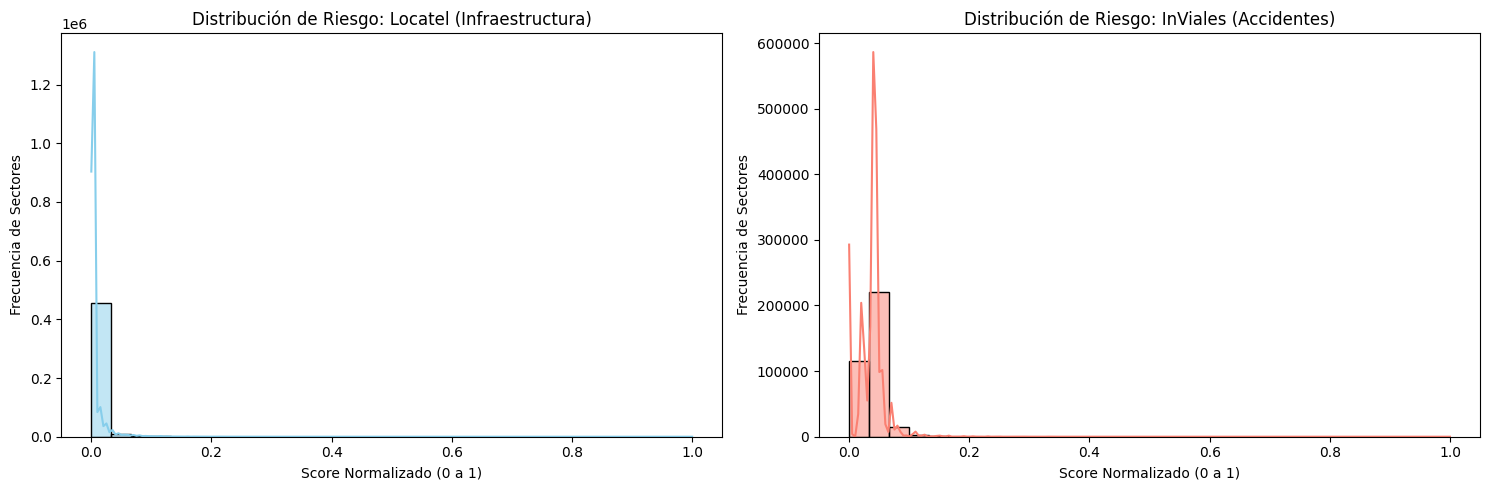

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_distribucion_scores(score_loc, score_inv):
    # Crear una figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Distribución Locatel (Infraestructura)
    sns.histplot(score_loc, kde=True, ax=axes[0], color='skyblue', bins=30)
    axes[0].set_title('Distribución de Riesgo: Locatel (Infraestructura)')
    axes[0].set_xlabel('Score Normalizado (0 a 1)')
    axes[0].set_ylabel('Frecuencia de Sectores')

    # 2. Distribución InViales (Siniestralidad)
    sns.histplot(score_inv, kde=True, ax=axes[1], color='salmon', bins=30)
    axes[1].set_title('Distribución de Riesgo: InViales (Accidentes)')
    axes[1].set_xlabel('Score Normalizado (0 a 1)')
    axes[1].set_ylabel('Frecuencia de Sectores')

    plt.tight_layout()
    # plt.savefig('distribucion_riesgos_unsupervised.png')
    plt.show()

# Ejecución
graficar_distribucion_scores(score_loc_cluster, score_inv_cluster)

In [109]:
import pandas as pd

df_red_ciclista = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/ABT_raiz_red_ciclista_completa_cdmx.parquet', engine='pyarrow')
df_red_ciclista

segment_id               street_name   alcaldia_name  \
0            30339493_274185917_0  Calzada San Antonio Abad  Miguel Hidalgo   
1            30339495_274187776_0  Calzada San Antonio Abad  Miguel Hidalgo   
2            30339495_274188569_0      Calle Juan A. Mateos  Miguel Hidalgo   
3            30339671_275512749_0       Calle Matías Romero  Miguel Hidalgo   
4            30339671_274840978_0       Calle Matías Romero  Miguel Hidalgo   
...                           ...                       ...             ...   
378244   13510366537_8170322212_0                      None  Miguel Hidalgo   
378245  13512352159_10080538299_0                      None  Miguel Hidalgo   
378246   13513077027_5902960431_0                      None  Miguel Hidalgo   
378247   13513077027_4074018101_0                      None  Miguel Hidalgo   
378248   13514379630_6363529743_0                      None  Miguel Hidalgo   

            highway lanes maxspeed  oneway    length  \
0             trunk     4       80    True 143.77452   
1             trunk     4       80    True 119.14354   
2       residential     1     None    True  58.28314   
3       residential     4     None   False  87.48934   
4       residential     4     None   False  12.83102   
...             ...   ...      ...     ...       ...   
378244      service  None     None   False  43.34251   
378245         path  None     None   False  10.34214   
378246      service  None     None   False  35.07223   
378247      service  None     None    True 199.48052   
378248      service  None     None   False 146.22971   

                                                 geometry  lat_start  \
0       b'\x01\x02\x00\x00\x00\x04\x00\x00\x00\xc0S\x1...   19.41806   
1       b'\x01\x02\x00\x00\x00\x02\x00\x00\x002l9<\xa9...   19.41027   
2       b'\x01\x02\x00\x00\x00\x03\x00\x00\x002l9<\xa9...   19.41027   
3       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00<v\x06\x...   19.37858   
4       b'\x01\x02\x00\x00\x00\x02\x00\x00\x00<v\x06\x...   19.37858   
...                                                   ...        ...   
378244  b'\x01\x02\x00\x00\x00\x03\x00\x00\x00.D=3w\xc...   19.50777   
378245  b'\x01\x02\x00\x00\x00\x02\x00\x00\x00M\xea\x1...   19.50938   
378246  b"\x01\x02\x00\x00\x00\x06\x00\x00\x00\xc0V\xa...   19.50324   
378247  b'\x01\x02\x00\x00\x00\x1d\x00\x00\x00\xc0V\xa...   19.50324   
378248  b"\x01\x02\x00\x00\x00\n\x00\x00\x00\x9e^)\xcb...   19.29949   

        lon_start  lat_end   lon_end junction bridge width service access  \
0       -99.13410 19.41934 -99.13392     None   None  None    None   None   
1       -99.13533 19.41133 -99.13517     None   None  None    None   None   
2       -99.13533 19.41023 -99.13478     None   None  None    None   None   
3       -99.15338 19.37842 -99.15256     None   None  None    None   None   
4       -99.15338 19.37860 -99.15350     None   None  None    None   None   
...           ...      ...       ...      ...    ...   ...     ...    ...   
378244  -99.21040 19.50743 -99.21057     None   None  None    None   None   
378245  -99.20956 19.50945 -99.20962     None   None  None    None   None   
378246  -99.20437 19.50332 -99.20410     None   None  None    None   None   
378247  -99.20437 19.50262 -99.20498     None   None  None    None   None   
378248  -99.21196 19.29880 -99.21086     None   None  None    None   None   

        ciclovia iluminacion  
0              0          no  
1              0          no  
2              0          no  
3              0          no  
4              0          no  
...          ...         ...  
378244         0          no  
378245         0          no  
378246         0          no  
378247         0          no  
378248         0          no  

[378249 rows x 20 columns]

In [110]:
df_red_ciclista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378249 entries, 0 to 378248
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   segment_id     378249 non-null  object 
 1   street_name    281213 non-null  object 
 2   alcaldia_name  378249 non-null  object 
 3   highway        378249 non-null  object 
 4   lanes          71505 non-null   object 
 5   maxspeed       34486 non-null   object 
 6   oneway         378249 non-null  bool   
 7   length         378249 non-null  float64
 8   geometry       378249 non-null  object 
 9   lat_start      378249 non-null  float64
 10  lon_start      378249 non-null  float64
 11  lat_end        378249 non-null  float64
 12  lon_end        378249 non-null  float64
 13  junction       914 non-null     object 
 14  bridge         1567 non-null    object 
 15  width          1586 non-null    object 
 16  service        7604 non-null    object 
 17  access         2885 non-null 

Decodificando WKB...


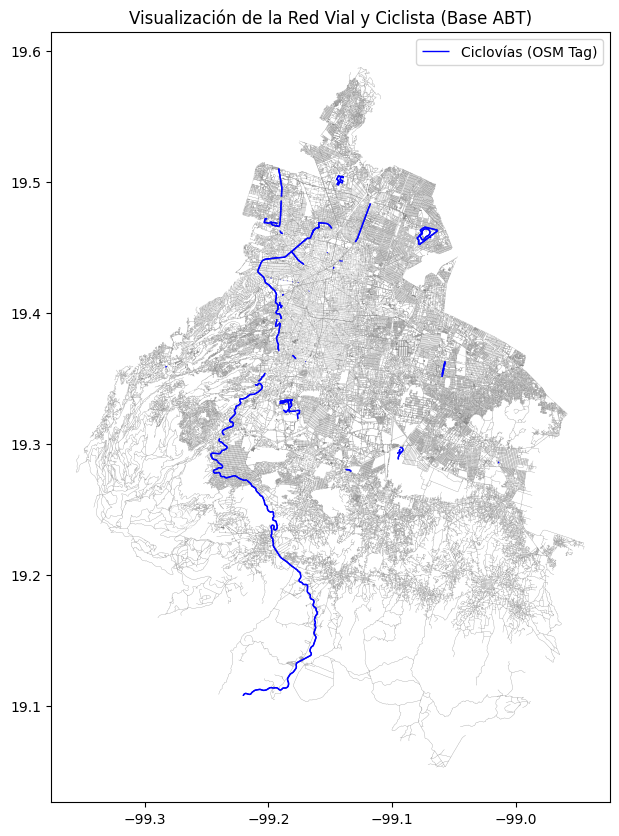

In [111]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from shapely import wkb
from shapely.geometry.base import BaseGeometry
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Validación inteligente: Solo decodifica si NO es ya una geometría
if not isinstance(df_red_ciclista['geometry'].iloc[0], BaseGeometry):
    print("Decodificando WKB...")
    df_red_ciclista['geometry'] = df_red_ciclista['geometry'].apply(lambda x: wkb.loads(x))
else:
    print("La geometría ya está decodificada.")

# 2. Crear el GeoDataFrame
gdf_red = gpd.GeoDataFrame(df_red_ciclista, geometry='geometry', crs="EPSG:4326")

# 3. Graficado robusto
fig, ax = plt.subplots(figsize=(10, 10))

# Red base
gdf_red.plot(ax=ax, color='gray', linewidth=0.2, alpha=0.5)

# Filtro de ciclovías basado en la columna 'highway'
# Usamos .fillna('') para evitar errores si hay valores nulos en highway
mask_ciclo = gdf_red['highway'].fillna('').str.contains('cycleway')

if mask_ciclo.any():
    gdf_red[mask_ciclo].plot(ax=ax, color='blue', linewidth=1, label='Ciclovías (OSM Tag)')
    plt.legend()
else:
    print("No se encontraron segmentos con la etiqueta 'cycleway'.")

plt.title("Visualización de la Red Vial y Ciclista (Base ABT)")
plt.show()

In [112]:
gdf_red.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 378249 entries, 0 to 378248
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   segment_id     378249 non-null  object  
 1   street_name    281213 non-null  object  
 2   alcaldia_name  378249 non-null  object  
 3   highway        378249 non-null  object  
 4   lanes          71505 non-null   object  
 5   maxspeed       34486 non-null   object  
 6   oneway         378249 non-null  bool    
 7   length         378249 non-null  float64 
 8   geometry       378249 non-null  geometry
 9   lat_start      378249 non-null  float64 
 10  lon_start      378249 non-null  float64 
 11  lat_end        378249 non-null  float64 
 12  lon_end        378249 non-null  float64 
 13  junction       914 non-null     object  
 14  bridge         1567 non-null    object  
 15  width          1586 non-null    object  
 16  service        7604 non-null    object  
 17  ac

In [113]:
gdf_red.columns

Index(['segment_id', 'street_name', 'alcaldia_name', 'highway', 'lanes',
       'maxspeed', 'oneway', 'length', 'geometry', 'lat_start', 'lon_start',
       'lat_end', 'lon_end', 'junction', 'bridge', 'width', 'service',
       'access', 'ciclovia', 'iluminacion'],
      dtype='object')

In [114]:
gdf_red_corto=gdf_red[['segment_id', 'length', 'geometry', 'lat_start', 'lon_start','lat_end', 'lon_end']]
gdf_red_corto

segment_id    length  \
0            30339493_274185917_0 143.77452   
1            30339495_274187776_0 119.14354   
2            30339495_274188569_0  58.28314   
3            30339671_275512749_0  87.48934   
4            30339671_274840978_0  12.83102   
...                           ...       ...   
378244   13510366537_8170322212_0  43.34251   
378245  13512352159_10080538299_0  10.34214   
378246   13513077027_5902960431_0  35.07223   
378247   13513077027_4074018101_0 199.48052   
378248   13514379630_6363529743_0 146.22971   

                                                 geometry  lat_start  \
0       LINESTRING (-99.1341 19.41806, -99.13409 19.41...   19.41806   
1       LINESTRING (-99.13533 19.41027, -99.13517 19.4...   19.41027   
2       LINESTRING (-99.13533 19.41027, -99.13483 19.4...   19.41027   
3       LINESTRING (-99.15338 19.37858, -99.15256 19.3...   19.37858   
4       LINESTRING (-99.15338 19.37858, -99.1535 19.3786)   19.37858   
...                                                   ...        ...   
378244  LINESTRING (-99.2104 19.50777, -99.21048 19.50...   19.50777   
378245  LINESTRING (-99.20956 19.50938, -99.20962 19.5...   19.50938   
378246  LINESTRING (-99.20437 19.50324, -99.20433 19.5...   19.50324   
378247  LINESTRING (-99.20437 19.50324, -99.20433 19.5...   19.50324   
378248  LINESTRING (-99.21196 19.29949, -99.21148 19.2...   19.29949   

        lon_start  lat_end   lon_end  
0       -99.13410 19.41934 -99.13392  
1       -99.13533 19.41133 -99.13517  
2       -99.13533 19.41023 -99.13478  
3       -99.15338 19.37842 -99.15256  
4       -99.15338 19.37860 -99.15350  
...           ...      ...       ...  
378244  -99.21040 19.50743 -99.21057  
378245  -99.20956 19.50945 -99.20962  
378246  -99.20437 19.50332 -99.20410  
378247  -99.20437 19.50262 -99.20498  
378248  -99.21196 19.29880 -99.21086  

[378249 rows x 7 columns]

In [115]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

def snapping_ultra_rapido(df_puntos, df_red):
    # 1. Extraer las coordenadas de la red (nodos de inicio)
    # No usamos geometry, solo los números de lat/lon que ya tienes
    nodos_red = df_red[['lat_start', 'lon_start']].values

    # 2. Construir el 'árbol' de búsqueda (esto es casi instantáneo)
    tree = cKDTree(nodos_red)

    # 3. Preparar los puntos de incidentes
    puntos_incidentes = df_puntos.reset_index()[['latitud', 'longitud']].values

    # 4. BUSQUEDA: Encontrar el índice del nodo más cercano para cada incidente
    # d es la distancia, i es el índice en la tabla de la red
    d, i = tree.query(puntos_incidentes, k=1)

    # 5. Asignar el segment_id correspondiente
    df_resultado = df_puntos.reset_index()
    df_resultado['segment_id'] = df_red.iloc[i]['segment_id'].values
    df_resultado['distancia_al_segmento'] = d

    return df_resultado

In [116]:
# Ejecución para tus bases (tardará segundos, no minutos)
locatel_vinculado = snapping_ultra_rapido(locatel_agrupado, gdf_red_corto)
inviales_vinculado = snapping_ultra_rapido(inviales_agrupado, gdf_red_corto)

In [117]:
locatel_vinculado

index      timestamp_fijo  latitud  longitud  tema_OTROS  \
0            0 2022-01-01 00:00:00 19.48830 -99.11590           0   
1            1 2022-01-01 01:00:00 19.19970 -99.15160           0   
2            2 2022-01-01 01:00:00 19.28380 -99.17240           0   
3            3 2022-01-01 02:00:00 19.47920 -99.18420           0   
4            4 2022-01-01 07:00:00 19.39700 -99.24390           0   
...        ...                 ...      ...       ...         ...   
471111  471111 2024-02-29 23:00:00 19.41660 -99.17760           0   
471112  471112 2024-02-29 23:00:00 19.47920 -99.21620           0   
471113  471113 2024-02-29 23:00:00 19.47980 -99.21660           0   
471114  471114 2024-02-29 23:00:00 19.49610 -99.08500           0   
471115  471115 2024-02-29 23:00:00 19.49770 -99.19830           0   

        tema_Riesgo_Fluidos_Drenaje  tema_Riesgo_Infraestructura_Critica  \
0                                 0                                    0   
1                                 0                                    1   
2                                 0                                    1   
3                                 0                                    0   
4                                 1                                    0   
...                             ...                                  ...   
471111                            0                                    1   
471112                            1                                    0   
471113                            0                                    0   
471114                            0                                    0   
471115                            0                                    0   

        tema_Riesgo_Infraestructura_alumbrado  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
471111                                      0   
471112                                      0   
471113                                      0   
471114                                      0   
471115                                      0   

        tema_Riesgo_Infraestructura_bacheo  tema_Riesgo_Obstruccion_Entorno  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   
...                                    ...                              ...   
471111                                   0                                0   
471112                                   0                                0   
471113                                   0                                1   
471114                                   0                                1   
471115                                   0                                1   

        ...  alc_MIGUEL HIDALGO  alc_MILPA ALTA  alc_TLAHUAC  alc_TLALPAN  \
0       ...                   0               0            0            0   
1       ...                   0               0            0            1   
2       ...                   0               0            0            1   
3       ...                   0               0            0            0   
4       ...                   1               0            0            0   
...     ...                 ...             ...          ...          ...   
471111  ...                   0               0            0            0   
471112  ...                   0               0            0            0   
471113  ...                   0     

In [118]:
inviales_vinculado

index      timestamp_fijo  latitud  longitud  ent_APLICATIVOS  \
0            0 2021-12-29 23:00:00 19.42160 -99.16370                0   
1            1 2021-12-31 20:00:00 19.30040 -99.14460                0   
2            2 2021-12-31 20:00:00 19.31460 -99.06580                0   
3            3 2021-12-31 20:00:00 19.34760 -99.08280                0   
4            4 2021-12-31 20:00:00 19.34770 -99.08280                0   
...        ...                 ...      ...       ...              ...   
355862  355862 2024-02-29 20:00:00 19.39730 -99.05410                0   
355863  355863 2024-02-29 20:00:00 19.41090 -99.11810                0   
355864  355864 2024-02-29 20:00:00 19.42600 -99.05520                0   
355865  355865 2024-02-29 20:00:00 19.42610 -99.05530                0   
355866  355866 2024-02-29 20:00:00 19.42870 -99.12520                0   

        ent_BOTÓN DE AUXILIO  ent_CÁMARA  ent_LECTOR DE PLACAS  \
0                          1           0                     0   
1                          0           0                     0   
2                          0           0                     0   
3                          0           0                     0   
4                          0           0                     0   
...                      ...         ...                   ...   
355862                     0           0                     0   
355863                     0           0                     0   
355864                     2           0                     0   
355865                     0           0                     0   
355866                     0           0                     0   

        ent_LLAMADA APP911  ent_LLAMADA DEL 911  ...  inc_Otros  \
0                        0                    0  ...          0   
1                        0                    1  ...          0   
2                        0                    1  ...          0   
3                        0                    1  ...          0   
4                        0                    1  ...          0   
...                    ...                  ...  ...        ...   
355862                   0                    1  ...          0   
355863                   0                    1  ...          0   
355864                   0                    0  ...          0   
355865                   0                    1  ...          0   
355866                   0                    0  ...          0   

        inc_Persona atrapada / desbarrancada  inc_Persona atropellada  \
0                                          0                        0   
1                                          0                        0   
2                                          0                        0   
3                                          0                        0   
4                                          0                        0   
...                                      ...                      ...   
355862                                     0                        0   
355863                                     0                        0   
355864                                     0                        0   
355865                                     0                        0   
355866                                     0                        0   

        inc_Vehiculo desbarrancado  inc_Vehículo atrapadovarado  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
355862                           0                            0   
355863                           0                            0   
355864                           0        

In [126]:
score_inv_cluster.info()

<class 'pandas.core.series.Series'>
MultiIndex: 355867 entries, (Timestamp('2021-12-29 23:00:00'), np.float64(19.4216), np.float64(-99.1637)) to (Timestamp('2024-02-29 20:00:00'), np.float64(19.4287), np.float64(-99.1252))
Series name: score_riesgo_cluster
Non-Null Count   Dtype  
--------------   -----  
355867 non-null  float64
dtypes: float64(1)
memory usage: 5.7 MB


In [124]:
score_inv_cluster

timestamp_fijo       latitud   longitud 
2021-12-29 23:00:00  19.42160  -99.16370   0.05170
2021-12-31 20:00:00  19.30040  -99.14460   0.04362
                     19.31460  -99.06580   0.04362
                     19.34760  -99.08280   0.04362
                     19.34770  -99.08280   0.04362
                                             ...  
2024-02-29 20:00:00  19.39730  -99.05410   0.05612
                     19.41090  -99.11810   0.03943
                     19.42600  -99.05520   0.06902
                     19.42610  -99.05530   0.04833
                     19.42870  -99.12520   0.04845
Name: score_riesgo_cluster, Length: 355867, dtype: float64

In [125]:
score_loc_cluster

timestamp_fijo       latitud   longitud 
2022-01-01 00:00:00  19.48830  -99.11590   0.00282
2022-01-01 01:00:00  19.19970  -99.15160   0.00038
                     19.28380  -99.17240   0.00038
2022-01-01 02:00:00  19.47920  -99.18420   0.00330
2022-01-01 07:00:00  19.39700  -99.24390   0.00337
                                             ...  
2024-02-29 23:00:00  19.41660  -99.17760   0.00078
                     19.47920  -99.21620   0.00330
                     19.47980  -99.21660   0.00328
                     19.49610  -99.08500   0.00282
                     19.49770  -99.19830   0.00328
Name: score_riesgo_cluster, Length: 471116, dtype: float64

In [129]:
import pandas as pd

def vincular_score_jerarquico(df_base, df_score_raw):
    print("--- Iniciando Vinculación de Score ---")

    # 1. Limpieza de df_base (Eliminar encabezados repetidos y convertir tipos)
    df_b = df_base[df_base['timestamp_fijo'] != 'timestamp_fijo'].copy()
    df_b['timestamp_fijo'] = pd.to_datetime(df_b['timestamp_fijo'], errors='coerce')
    df_b['latitud'] = pd.to_numeric(df_b['latitud'], errors='coerce')
    df_b['longitud'] = pd.to_numeric(df_b['longitud'], errors='coerce')

    # 2. Preparar df_score (Manejo de índices)
    df_s = df_score_raw.reset_index()

    # 3. DINÁMICO: Identificar la columna del Score
    # Si no se llama exactamente 'Score_riesgo_cluster', buscamos la que contenga 'Score' o sea numérica
    posibles_nombres = [c for c in df_s.columns if 'Score' in c or 'riesgo' in c]

    if 'Score_riesgo_cluster' in df_s.columns:
        col_score = 'Score_riesgo_cluster'
    elif posibles_nombres:
        col_score = posibles_nombres[0]
        print(f" 'Score_riesgo_cluster' no hallado. Usando: '{col_score}'")
    else:
        # Si es el último recurso (a veces reset_index nombra a la columna '0')
        col_score = df_s.columns[-1]
        print(f" Nombre no identificado. Usando la última columna: '{col_score}'")

    # 4. Asegurar tipos en Score para el cruce
    df_s['timestamp_fijo'] = pd.to_datetime(df_s['timestamp_fijo'], errors='coerce')
    df_s['latitud'] = pd.to_numeric(df_s['latitud'], errors='coerce')
    df_s['longitud'] = pd.to_numeric(df_s['longitud'], errors='coerce')

    # 5. Homologar Coordenadas (Redondeo a 6 decimales)
    precision = 6
    df_b['latitud'] = df_b['latitud'].round(precision)
    df_b['longitud'] = df_b['longitud'].round(precision)
    df_s['latitud'] = df_s['latitud'].round(precision)
    df_s['longitud'] = df_s['longitud'].round(precision)

    # 6. Cruce Final
    # Solo traemos las llaves y la columna de score encontrada
    df_final = pd.merge(
        df_b,
        df_s[['timestamp_fijo', 'latitud', 'longitud', col_score]],
        on=['timestamp_fijo', 'latitud', 'longitud'],
        how='left'
    )

    # Renombrar la columna a tu estándar deseado si es necesario
    df_final = df_final.rename(columns={col_score: 'Score_riesgo_cluster'})

    print(f" Cruce completado. Registros: {len(df_final):,}")
    return df_final

# --- EJECUCIÓN ---
inviales_completo = vincular_score_jerarquico(inviales_vinculado, score_inv_cluster)

--- Iniciando Vinculación de Score ---
⚠️ 'Score_riesgo_cluster' no hallado. Usando: 'score_riesgo_cluster'
✅ Cruce completado. Registros: 355,867


In [130]:
inviales_completo

index      timestamp_fijo  latitud  longitud  ent_APLICATIVOS  \
0            0 2021-12-29 23:00:00 19.42160 -99.16370                0   
1            1 2021-12-31 20:00:00 19.30040 -99.14460                0   
2            2 2021-12-31 20:00:00 19.31460 -99.06580                0   
3            3 2021-12-31 20:00:00 19.34760 -99.08280                0   
4            4 2021-12-31 20:00:00 19.34770 -99.08280                0   
...        ...                 ...      ...       ...              ...   
355862  355862 2024-02-29 20:00:00 19.39730 -99.05410                0   
355863  355863 2024-02-29 20:00:00 19.41090 -99.11810                0   
355864  355864 2024-02-29 20:00:00 19.42600 -99.05520                0   
355865  355865 2024-02-29 20:00:00 19.42610 -99.05530                0   
355866  355866 2024-02-29 20:00:00 19.42870 -99.12520                0   

        ent_BOTÓN DE AUXILIO  ent_CÁMARA  ent_LECTOR DE PLACAS  \
0                          1           0                     0   
1                          0           0                     0   
2                          0           0                     0   
3                          0           0                     0   
4                          0           0                     0   
...                      ...         ...                   ...   
355862                     0           0                     0   
355863                     0           0                     0   
355864                     2           0                     0   
355865                     0           0                     0   
355866                     0           0                     0   

        ent_LLAMADA APP911  ent_LLAMADA DEL 911  ...  \
0                        0                    0  ...   
1                        0                    1  ...   
2                        0                    1  ...   
3                        0                    1  ...   
4                        0                    1  ...   
...                    ...                  ...  ...   
355862                   0                    1  ...   
355863                   0                    1  ...   
355864                   0                    0  ...   
355865                   0                    1  ...   
355866                   0                    0  ...   

        inc_Persona atrapada / desbarrancada  inc_Persona atropellada  \
0                                          0                        0   
1                                          0                        0   
2                                          0                        0   
3                                          0                        0   
4                                          0                        0   
...                                      ...                      ...   
355862                                     0                        0   
355863                                     0                        0   
355864                                     0                        0   
355865                                     0                        0   
355866                                     0                        0   

        inc_Vehiculo desbarrancado  inc_Vehículo atrapadovarado  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
355862                           0                            0   
355863                           0                            0   
355864                           0                            0   
355865                           0                            0   
355866                           0      

In [131]:
import pandas as pd

def vincular_score_locatel(df_base_loc, df_score_raw):
    print("--- Iniciando Vinculación de Score de Locatel ---")

    # 1. Limpieza de df_base (Evitar encabezados repetidos y asegurar tipos)
    df_b = df_base_loc[df_base_loc['timestamp_fijo'] != 'timestamp_fijo'].copy()
    df_b['timestamp_fijo'] = pd.to_datetime(df_b['timestamp_fijo'], errors='coerce')
    df_b['latitud'] = pd.to_numeric(df_b['latitud'], errors='coerce')
    df_b['longitud'] = pd.to_numeric(df_b['longitud'], errors='coerce')

    # 2. Preparar df_score (Bajar índices: timestamp_fijo, latitud, longitud)
    df_s = df_score_raw.reset_index()

    # 3. Identificación dinámica de la columna Score
    # Buscamos columnas que tengan 'Score' o 'riesgo' en el nombre
    posibles_nombres = [c for c in df_s.columns if 'Score' in c or 'riesgo' in c]

    if 'Score_riesgo_cluster' in df_s.columns:
        col_score = 'Score_riesgo_cluster'
    elif posibles_nombres:
        col_score = posibles_nombres[0]
        print(f" Nombre esperado no hallado. Usando: '{col_score}'")
    else:
        col_score = df_s.columns[-1]
        print(f" Nombre no identificado. Usando última columna: '{col_score}'")

    # 4. Asegurar tipos y precisión en Score
    df_s['timestamp_fijo'] = pd.to_datetime(df_s['timestamp_fijo'], errors='coerce')
    df_s['latitud'] = pd.to_numeric(df_s['latitud'], errors='coerce')
    df_s['longitud'] = pd.to_numeric(df_s['longitud'], errors='coerce')

    # 5. Redondeo de coordenadas (Precisión 6 decimales)
    precision = 6
    df_b['latitud'] = df_b['latitud'].round(precision)
    df_b['longitud'] = df_b['longitud'].round(precision)
    df_s['latitud'] = df_s['latitud'].round(precision)
    df_s['longitud'] = df_s['longitud'].round(precision)

    # 6. Cruce Final (Left Join)
    df_final = pd.merge(
        df_b,
        df_s[['timestamp_fijo', 'latitud', 'longitud', col_score]],
        on=['timestamp_fijo', 'latitud', 'longitud'],
        how='left'
    )

    # Renombrar para mantener el estándar del proyecto
    df_final = df_final.rename(columns={col_score: 'Score_riesgo_cluster'})

    # 7. Reporte de Calidad
    n_exitos = df_final['Score_riesgo_cluster'].notna().sum()
    pct_exito = (n_exitos / len(df_final)) * 100
    print(f" Vinculación finalizada: {n_exitos:,} registros con score ({pct_exito:.2f}%)")

    return df_final

# --- EJECUCIÓN ---
locatel_final = vincular_score_locatel(locatel_vinculado, score_loc_cluster)

--- Iniciando Vinculación de Score de Locatel ---
 Nombre esperado no hallado. Usando: 'score_riesgo_cluster'
 Vinculación finalizada: 471,116 registros con score (100.00%)


In [132]:
locatel_final

index      timestamp_fijo  latitud  longitud  tema_OTROS  \
0            0 2022-01-01 00:00:00 19.48830 -99.11590           0   
1            1 2022-01-01 01:00:00 19.19970 -99.15160           0   
2            2 2022-01-01 01:00:00 19.28380 -99.17240           0   
3            3 2022-01-01 02:00:00 19.47920 -99.18420           0   
4            4 2022-01-01 07:00:00 19.39700 -99.24390           0   
...        ...                 ...      ...       ...         ...   
471111  471111 2024-02-29 23:00:00 19.41660 -99.17760           0   
471112  471112 2024-02-29 23:00:00 19.47920 -99.21620           0   
471113  471113 2024-02-29 23:00:00 19.47980 -99.21660           0   
471114  471114 2024-02-29 23:00:00 19.49610 -99.08500           0   
471115  471115 2024-02-29 23:00:00 19.49770 -99.19830           0   

        tema_Riesgo_Fluidos_Drenaje  tema_Riesgo_Infraestructura_Critica  \
0                                 0                                    0   
1                                 0                                    1   
2                                 0                                    1   
3                                 0                                    0   
4                                 1                                    0   
...                             ...                                  ...   
471111                            0                                    1   
471112                            1                                    0   
471113                            0                                    0   
471114                            0                                    0   
471115                            0                                    0   

        tema_Riesgo_Infraestructura_alumbrado  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
471111                                      0   
471112                                      0   
471113                                      0   
471114                                      0   
471115                                      0   

        tema_Riesgo_Infraestructura_bacheo  tema_Riesgo_Obstruccion_Entorno  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   
...                                    ...                              ...   
471111                                   0                                0   
471112                                   0                                0   
471113                                   0                                1   
471114                                   0                                1   
471115                                   0                                1   

        ...  alc_MILPA ALTA  alc_TLAHUAC  alc_TLALPAN  alc_TLÁHUAC  \
0       ...               0            0            0            0   
1       ...               0            0            1            0   
2       ...               0            0            1            0   
3       ...               0            0            0            0   
4       ...               0            0            0            0   
...     ...             ...          ...          ...          ...   
471111  ...               0            0            0            0   
471112  ...               0            0            0            0   
471113  ...               0            0            0            0   
471114  ...               0  

In [133]:
locatel_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471116 entries, 0 to 471115
Data columns (total 32 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   index                                  471116 non-null  int64         
 1   timestamp_fijo                         471116 non-null  datetime64[ns]
 2   latitud                                471116 non-null  float64       
 3   longitud                               471116 non-null  float64       
 4   tema_OTROS                             471116 non-null  int64         
 5   tema_Riesgo_Fluidos_Drenaje            471116 non-null  int64         
 6   tema_Riesgo_Infraestructura_Critica    471116 non-null  int64         
 7   tema_Riesgo_Infraestructura_alumbrado  471116 non-null  int64         
 8   tema_Riesgo_Infraestructura_bacheo     471116 non-null  int64         
 9   tema_Riesgo_Obstruccion_Entorno        471116 no

In [135]:
locatel_final.columns

Index(['index', 'timestamp_fijo', 'latitud', 'longitud', 'tema_OTROS',
       'tema_Riesgo_Fluidos_Drenaje', 'tema_Riesgo_Infraestructura_Critica',
       'tema_Riesgo_Infraestructura_alumbrado',
       'tema_Riesgo_Infraestructura_bacheo', 'tema_Riesgo_Obstruccion_Entorno',
       'tema_Riesgo_Seguridad_Percepcion', 'alc_ALVARO OBREGON',
       'alc_AZCAPOTZALCO', 'alc_BENITO JUAREZ', 'alc_COYOACAN',
       'alc_CUAJIMALPA DE MORELOS', 'alc_CUAUHTEMOC', 'alc_GUSTAVO A. MADERO',
       'alc_IZTACALCO', 'alc_IZTAPALAPA', 'alc_LA MAGDALENA CONTRERAS',
       'alc_MIGUEL HIDALGO', 'alc_MILPA ALTA', 'alc_TLAHUAC', 'alc_TLALPAN',
       'alc_TLÁHUAC', 'alc_VENUSTIANO CARRANZA', 'alc_XOCHIMILCO',
       'alc_ÁLVARO OBREGÓN', 'segment_id', 'distancia_al_segmento',
       'Score_riesgo_cluster'],
      dtype='object')

In [136]:
locatel_completo=locatel_final[['timestamp_fijo', 'segment_id', 'latitud', 'longitud', 'tema_OTROS',
       'tema_Riesgo_Fluidos_Drenaje', 'tema_Riesgo_Infraestructura_Critica',
       'tema_Riesgo_Infraestructura_alumbrado',
       'tema_Riesgo_Infraestructura_bacheo', 'tema_Riesgo_Obstruccion_Entorno',
       'tema_Riesgo_Seguridad_Percepcion', 'distancia_al_segmento',
       'Score_riesgo_cluster']].copy()
locatel_completo

timestamp_fijo               segment_id  latitud  longitud  \
0      2022-01-01 00:00:00    390414841_390414845_0 19.48830 -99.11590   
1      2022-01-01 01:00:00  6837003817_6837003815_0 19.19970 -99.15160   
2      2022-01-01 01:00:00  8337425155_8337425157_0 19.28380 -99.17240   
3      2022-01-01 02:00:00  1932473913_6135781946_0 19.47920 -99.18420   
4      2022-01-01 07:00:00  2121884586_8484264121_0 19.39700 -99.24390   
...                    ...                      ...      ...       ...   
471111 2024-02-29 23:00:00      49587869_49587853_0 19.41660 -99.17760   
471112 2024-02-29 23:00:00    372452217_372452180_0 19.47920 -99.21620   
471113 2024-02-29 23:00:00    372452575_372452571_0 19.47980 -99.21660   
471114 2024-02-29 23:00:00   5846366559_385742477_0 19.49610 -99.08500   
471115 2024-02-29 23:00:00    385641988_385641939_0 19.49770 -99.19830   

        tema_OTROS  tema_Riesgo_Fluidos_Drenaje  \
0                0                            0   
1                0                            0   
2                0                            0   
3                0                            0   
4                0                            1   
...            ...                          ...   
471111           0                            0   
471112           0                            1   
471113           0                            0   
471114           0                            0   
471115           0                            0   

        tema_Riesgo_Infraestructura_Critica  \
0                                         0   
1                                         1   
2                                         1   
3                                         0   
4                                         0   
...                                     ...   
471111                                    1   
471112                                    0   
471113                                    0   
471114                                    0   
471115                                    0   

        tema_Riesgo_Infraestructura_alumbrado  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
471111                                      0   
471112                                      0   
471113                                      0   
471114                                      0   
471115                                      0   

        tema_Riesgo_Infraestructura_bacheo  tema_Riesgo_Obstruccion_Entorno  \
0                                        0                                1   
1                                        0                                0   
2                                        0                                0   
3                                        0                                0   
4                                        0                                0   
...                                    ...                              ...   
471111                                   0                                0   
471112                                   0                                0   
471113                                   0                                1   
471114                                   0                                1   
471115                                   0                                1   

        tema_Riesgo_Seguridad_Percepcion  distancia_al_segmento  \
0                                      0                0.00068   
1                                      0                0.00023   
2                                      0                0.00027   
3                                      0                0.00012   
4                                      0                0.00019   
...  

In [134]:
inviales_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355867 entries, 0 to 355866
Data columns (total 46 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   index                                 355867 non-null  int64         
 1   timestamp_fijo                        355867 non-null  datetime64[ns]
 2   latitud                               355867 non-null  float64       
 3   longitud                              355867 non-null  float64       
 4   ent_APLICATIVOS                       355867 non-null  int64         
 5   ent_BOTÓN DE AUXILIO                  355867 non-null  int64         
 6   ent_CÁMARA                            355867 non-null  int64         
 7   ent_LECTOR DE PLACAS                  355867 non-null  int64         
 8   ent_LLAMADA APP911                    355867 non-null  int64         
 9   ent_LLAMADA DEL 911                   355867 non-null  int6

In [137]:
inviales_completo.columns

Index(['index', 'timestamp_fijo', 'latitud', 'longitud', 'ent_APLICATIVOS',
       'ent_BOTÓN DE AUXILIO', 'ent_CÁMARA', 'ent_LECTOR DE PLACAS',
       'ent_LLAMADA APP911', 'ent_LLAMADA DEL 911', 'ent_RADIO', 'ent_REDES',
       'ent_SOS MUJERES *765', 'alarm_DELITO', 'alarm_EMERGENCIA',
       'alarm_FALSA ALARMA', 'alarm_INCIDENTES EXTERNOS',
       'alarm_URGENCIAS MEDICAS', 'tipo_Accidente', 'tipo_Cadáver',
       'tipo_Detención ciudadana', 'tipo_Lesionado', 'tipo_Mi Calle',
       'tipo_Mi Taxi', 'tipo_Sismo', 'inc_Accidente automovilístico',
       'inc_Atropellado', 'inc_Choque con lesionados',
       'inc_Choque con prensados', 'inc_Choque sin lesionados', 'inc_Ciclista',
       'inc_Ferroviario', 'inc_Incidente de tránsito', 'inc_Monopatín',
       'inc_Motociclista', 'inc_Otros', 'inc_Persona atrapada / desbarrancada',
       'inc_Persona atropellada', 'inc_Vehiculo desbarrancado',
       'inc_Vehículo atrapadovarado', 'inc_Volcadura', 'anio', 'mes_anio',
       'segment_id

In [138]:
inviales_completo=inviales_completo[['timestamp_fijo', 'segment_id', 'latitud', 'longitud',
       'tipo_Accidente',
       'inc_Atropellado',
       'inc_Choque con lesionados',
       'inc_Choque con prensados',
       'inc_Choque sin lesionados',
       'inc_Ciclista',
       'inc_Monopatín',
       'inc_Motociclista', 'inc_Otros',
       'distancia_al_segmento', 'Score_riesgo_cluster']].copy()
inviales_completo

timestamp_fijo               segment_id  latitud  longitud  \
0      2021-12-29 23:00:00    268384051_268384053_0 19.42160 -99.16370   
1      2021-12-31 20:00:00  1130218252_2262442158_0 19.30040 -99.14460   
2      2021-12-31 20:00:00   516609901_6135639252_0 19.31460 -99.06580   
3      2021-12-31 20:00:00   506862630_9497451467_0 19.34760 -99.08280   
4      2021-12-31 20:00:00   506862630_9497451467_0 19.34770 -99.08280   
...                    ...                      ...      ...       ...   
355862 2024-02-29 20:00:00    302590732_302590729_0 19.39730 -99.05410   
355863 2024-02-29 20:00:00    274315329_274203919_0 19.41090 -99.11810   
355864 2024-02-29 20:00:00    387799594_387799602_0 19.42600 -99.05520   
355865 2024-02-29 20:00:00    387799594_387799602_0 19.42610 -99.05530   
355866 2024-02-29 20:00:00    271022416_271022370_0 19.42870 -99.12520   

        tipo_Accidente  inc_Atropellado  inc_Choque con lesionados  \
0                    0                1                          0   
1                    1                0                          0   
2                    1                0                          0   
3                    1                0                          0   
4                    1                0                          0   
...                ...              ...                        ...   
355862               1                0                          0   
355863               1                0                          1   
355864               2                0                          2   
355865               1                0                          0   
355866               1                0                          1   

        inc_Choque con prensados  inc_Choque sin lesionados  inc_Ciclista  \
0                              0                          0             0   
1                              0                          1             0   
2                              0                          1             0   
3                              0                          1             0   
4                              0                          1             0   
...                          ...                        ...           ...   
355862                         0                          1             0   
355863                         0                          0             0   
355864                         0                          0             0   
355865                         0                          0             0   
355866                         0                          0             0   

        inc_Monopatín  inc_Motociclista  inc_Otros  distancia_al_segmento  \
0                   0                 0          0                0.00006   
1                   0                 0          0                0.00038   
2                   0                 0          0                0.00023   
3                   0                 0          0                0.00014   
4                   0                 0          0                0.00012   
...               ...               ...        ...                    ...   
355862              0                 0          0                0.00066   
355863              0                 0          0                0.00011   
355864              0                 0          0                0.00012   
355865              0                 1          0                0.00002   
355866              0                 0          0                0.00006   

        Score_riesgo_cluster  
0                    0.05170  
1                    0.04362  
2                    0.04362  
3                    0.04362  
4                    0.04362  
...                      ...  
355862               0.05612  
355863               0.03943  
355864               0.06902  
355865               0.04833  
355866               0.04845  

[355867 rows x 15 columns]

In [141]:
import geopandas as gpd
import pandas as pd
import os

# 1. Definir rutas
folder_path = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados'
file_name = 'DB_Accidentes.parquet'
full_path_geoparquet = os.path.join(folder_path, file_name)

# 2. Crear el GeoDataFrame correctamente
# Usamos latitud y longitud para crear la columna geometry de forma inmediata
if not isinstance(inviales_completo, gpd.GeoDataFrame):
    print("--- Convirtiendo a GeoDataFrame ---")
    inviales_completo = gpd.GeoDataFrame(
        inviales_completo,
        geometry=gpd.points_from_xy(inviales_completo['longitud'], inviales_completo['latitud']),
        crs="EPSG:4326"
    )
else:
    inviales_completo = inviales_completo.copy()

# 3. Guardar el objeto correcto (df_abt_final)
# Es importante guardar df_abt_final, que es el que ya tiene la geometría oficial
inviales_completo.to_parquet(full_path_geoparquet)

print(f" ¡Éxito! Guardado como GeoParquet en: {full_path_geoparquet}")
print(f"Registros guardados: {len(inviales_completo):,}")

--- Convirtiendo a GeoDataFrame ---
✅ ¡Éxito! Guardado como GeoParquet en: /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados/DB_Accidentes.parquet
Registros guardados: 355,867


In [143]:
import geopandas as gpd
import pandas as pd
import os

# 1. Definir rutas
folder_path = '/content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados'
file_name = 'DB_Infraestructura.parquet'
full_path_geoparquet = os.path.join(folder_path, file_name)

# 2. Crear el GeoDataFrame correctamente
# Usamos latitud y longitud para crear la columna geometry de forma inmediata
if not isinstance(locatel_completo, gpd.GeoDataFrame):
    print("--- Convirtiendo a GeoDataFrame ---")
    locatel_completo = gpd.GeoDataFrame(
        locatel_completo,
        geometry=gpd.points_from_xy(locatel_completo['longitud'], locatel_completo['latitud']),
        crs="EPSG:4326"
    )
else:
    locatel_completo = locatel_completo.copy()

# 3. Guardar el objeto correcto (df_abt_final)
# Es importante guardar df_abt_final, que es el que ya tiene la geometría oficial
locatel_completo.to_parquet(full_path_geoparquet)

print(f" ¡Éxito! Guardado como GeoParquet en: {full_path_geoparquet}")
print(f"Registros guardados: {len(locatel_completo):,}")

--- Convirtiendo a GeoDataFrame ---
✅ ¡Éxito! Guardado como GeoParquet en: /content/drive/MyDrive/Colab Notebooks/Bases_datos_Proy5/Resultados/DB_Infraestructura.parquet
Registros guardados: 471,116
